In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import glob
import torch as t
import pickle
import numpy as np
from numpy import corrcoef as ncorrcoef
import bmctool

In [2]:
plt.rcParams.update({'font.size': 11})

## Setup

In [3]:
from wasabi.data import Data
from wasabi.trainer import Trainer
from wasabi.auxiliary_functions import load_config, save_config, load_config_from_model, zip_and_del_tb
from wasabi.loss import GNLL
from wasabi.eval_wasabi import EvalWasabi
from wasabi.auxiliary_functions import load_config_from_model

In [4]:
# take time
start_time = time.time()

In [5]:
# data paths
sweep12x = "/home/henrik/work/python/WASABInet/data/testdata/20210720_20210706_WASABITI_sweep12_sim/20210720_X_20210706_WASABITI_sweep12_sim.pt"
sweep12y = "/home/henrik/work/python/WASABInet/data/testdata/20210720_20210706_WASABITI_sweep12_sim/20210720_y_20210706_WASABITI_sweep12_sim.pt"

sweep12xAna = "/home/henrik/work/python/WASABInet/data/testdata/20211119_WASABITI_sweep12_analytical_testdata/20211119_X_WASABITI_sweep12_analytical_testdata.pt"
sweep12yAna = "/home/henrik/work/python/WASABInet/data/testdata/20211119_WASABITI_sweep12_analytical_testdata/20211119_y_WASABITI_sweep12_analytical_testdata.pt"

sweep12x_T2_75ms = "/home/henrik/work/python/WASABInet/data/testdata/20211109_X_WASABITI_sweep12_testdata_T2_75ms.pt"
sweep12y_T2_75ms = "/home/henrik/work/python/WASABInet/data/testdata/20211109_y_WASABITI_sweep12_testdata_T2_75ms.pt"

In [6]:
# index for Master thesis
counter = 1

def get_counter():
    tmp = counter
    counter += 1
    return tmp


def extract_key_value(path, key):
    config = load_config_from_model(path)
    return config[key]

def extract_val_loss(path_list):
    loss_val = []
    for i in path_list:
        loss_val += [(t.load(i)['loss_val'][-1][1])]
    return loss_val

In [7]:
# functions

def loop_eval(path_list, name_list, x_file=sweep12x, y_files=sweep12y, data_type="BMCTool"):
    
    for i in range(len(path_list)):
        # init
        eval_wasabi = EvalWasabi(trainer=path_list[i], 
                                 data_type="BMCTool", 
                                 net_to_load=path_list[i], 
                                 x_file=sweep12x, 
                                 y_file=sweep12y)
        
        epoch = eval_wasabi.trainer[0].epochCount

        # predict
        eval_wasabi.predict()

        # parameter check
        eval_wasabi.parameter_min_max_check(save_file=True, 
                                            net_name=name_list[i]+"_{}epochs".format(epoch), 
                                            print_param=False)

In [8]:
def delta():
    """returns the delta symbol"""
    return '\u0394'

def mu():
    """returns the mu symbol"""
    return '\u03BC'

subscript = {0:'\u2080',
             1:'\u2081',
            2:'\u2082',
            3:'\u2083',
            4:'\u2084',
            5:'\u2085',
            6:'\u2086',
            7:'\u2087',
            8:'\u2088',
            9:'\u2089'}


str_param = {'dB0': '\u0394B{}'.format(subscript[0]),
            'B1': 'B{}'.format(subscript[1]),
            'T1': 'T{}'.format(subscript[1])}

def case(title: str):
    """chooses adjustments to title"""
    # dB0
    if title.count('mean_abs_dB0'):
        return "\u03BC(|\u0394B{} err.|) in [ppm]".format(subscript[0])
    elif title.count('max_abs_dB0'):
        return "max(|\u0394B{} err.|) in [ppm]".format(subscript[0])
    elif title.count('mean_rel_dB0'):
        return "\u03BC(rel. \u0394B{} err.) in [%]".format(subscript[0])
    # B1
    elif title.count('mean_abs_B1'):
        return "\u03BC(|B{} err.|) in [\u03BCT]".format(subscript[1])
    elif title.count('max_abs_B1'):
        return "max(|B{} err.|) in [\u03BCT]".format(subscript[1])
    elif title.count('mean_rel_B1'):
        return "\u03BC(rel. B{} err.) in [%]".format(subscript[1])
    # T1
    elif title.count('mean_abs_T1'):
        return "\u03BC(|T{} err.|) in [ms]".format(subscript[1])
    elif title.count('max_abs_T1'):
        return "max(|T{} err.|) in [ms]".format(subscript[1])
    elif title.count('mean_rel_T1'):
        return "\u03BC(rel. T{} err.) in [%]".format(subscript[1])
    else:
        return "ERROR"
    
print(case('mean_rel_T1'))

μ(rel. T₁ err.) in [%]


## Evaluation

### Batchsize

In [28]:
batchsize_path = sorted(glob.glob("output/*batchsize*/*model_autosave*"))
batchname_path = ["batchsize" + str(i+1) + "_sweep12" for i in range(len(batchsize_path))]
print("\n".join(batchsize_path),"\n", "\n".join(batchname_path))

output/2021_10_23_sweep12_2x256_batchsize1/2021_10_23_sweep12_2x256_batchsize1_model_autosave.pt
output/2021_10_23_sweep12_2x256_batchsize2/2021_10_23_sweep12_2x256_batchsize2_model_autosave.pt
output/2021_10_23_sweep12_2x256_batchsize3/2021_10_23_sweep12_2x256_batchsize3_model_autosave.pt
output/2021_10_23_sweep12_2x256_batchsize4/2021_10_23_sweep12_2x256_batchsize4_model_autosave.pt
output/2021_10_23_sweep12_2x256_batchsize5/2021_10_23_sweep12_2x256_batchsize5_model_autosave.pt 
 batchsize1_sweep12
batchsize2_sweep12
batchsize3_sweep12
batchsize4_sweep12
batchsize5_sweep12


In [8]:
#loop_eval(path_list=batchsize_path, name_list=batchname_path)

100%|######################################| 2560/2560 [00:20<00:00, 122.30it/s]


### Dropout Percent

In [29]:
dropout_path = sorted(glob.glob("output/*dropout_[0-9]*/*model_autosave*"))
dropoutname_path = ["dropout"+ dropout_path[i].split("_")[-3] + "_sweep12" for i in range(len(dropout_path))]
print("\n".join(dropout_path), "\n", "\n".join(dropoutname_path))

output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01_model_autosave.pt
output/2021_09_24_sweep12_2x256_dropout_03/2021_09_24_sweep12_2x256_dropout_03_model_autosave.pt
output/2021_09_24_sweep12_2x256_dropout_05/2021_09_24_sweep12_2x256_dropout_05_model_autosave.pt
output/2021_09_24_sweep12_2x256_dropout_10/2021_09_24_sweep12_2x256_dropout_10_model_autosave.pt
output/2021_09_24_sweep12_2x256_dropout_15/2021_09_24_sweep12_2x256_dropout_15_model_autosave.pt 
 dropout01_sweep12
dropout03_sweep12
dropout05_sweep12
dropout10_sweep12
dropout15_sweep12


In [10]:
#loop_eval(path_list=dropout_path, name_list=dropoutname_path)

100%|######################################| 2560/2560 [00:25<00:00, 100.78it/s]


### Dropout Larger & Longer

In [11]:
dropout_path = ['output/2021_09_24_sweep12_2x256_dropout/2021_09_24_sweep12_2x256_dropout_model_autosave.pt',
'output/2021_09_24_sweep12_2x256_dropout_larger/2021_09_24_sweep12_2x256_dropout_larger_model_autosave.pt']
dropoutname_path = ["dropout10_sweep12", "dropout_larger_sweep12"]
["dropout"+ "_sweep12" for i in range(len(dropout_path))]
print("\n".join(dropout_path), "\n", "\n".join(dropoutname_path))

output/2021_09_24_sweep12_2x256_dropout/2021_09_24_sweep12_2x256_dropout_model_autosave.pt
output/2021_09_24_sweep12_2x256_dropout_larger/2021_09_24_sweep12_2x256_dropout_larger_model_autosave.pt 
 dropout10_sweep12
dropout_larger_sweep12


In [12]:
#loop_eval(path_list=dropout_path, name_list=dropoutname_path)

100%|######################################| 2560/2560 [00:22<00:00, 111.32it/s]


### SGD

In [13]:
sgd_path = sorted(glob.glob("output/*SGD*/*autosave*"))
sgdname_path = ["SGD" + "_sweep12" for i in range(len(sgd_path))]
print("\n".join(sgd_path), "\n", "\n".join(sgdname_path))

output/2021_10_20_sweep12_2x256_SGD_lr0001/2021_10_20_sweep12_2x256_SGD_lr0001_model_autosave.pt 
 SGD_sweep12


In [14]:
#loop_eval(path_list=sgd_path, name_list=sgdname_path)

100%|######################################| 2560/2560 [00:18<00:00, 139.24it/s]


### Net size

In [30]:
size_path = sorted(glob.glob("output/*2021_07_29_sweep12_[0-9]x[0-9][0-9][0-9]/*autosave*"))
sizename_path = [size_path[i].split("_")[-3] + "_sweep12" for i in range(len(size_path))]
print("\n".join(size_path), "\n", "\n".join(sizename_path))

output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_model_autosave.pt
output/2021_07_29_sweep12_3x128/2021_07_29_sweep12_3x128_model_autosave.pt
output/2021_07_29_sweep12_4x128/2021_07_29_sweep12_4x128_model_autosave.pt
output/2021_07_29_sweep12_6x128/2021_07_29_sweep12_6x128_model_autosave.pt
output/2021_07_29_sweep12_6x256/2021_07_29_sweep12_6x256_model_autosave.pt 
 2x256_sweep12
3x128_sweep12
4x128_sweep12
6x128_sweep12
6x256_sweep12


In [16]:
#loop_eval(path_list=size_path, name_list=sizename_path)

100%|#######################################| 2560/2560 [00:29<00:00, 86.40it/s]


### Activation Function

In [31]:
act_path = sorted(glob.glob("output/*2021_07_29_sweep12_[0-9]x[0-9][0-9][0-9]_*/*autosave*"))
actname_path = [act_path[i].split("_")[-3] + "_sweep12" for i in range(len(act_path))]
print("\n".join(act_path), "\n", "\n".join(actname_path))

output/2021_07_29_sweep12_4x128_relu/2021_07_29_sweep12_4x128_relu_model_autosave.pt
output/2021_07_29_sweep12_4x128_sigmoid/2021_07_29_sweep12_4x128_sigmoid_model_autosave.pt
output/2021_07_29_sweep12_4x128_tanh/2021_07_29_sweep12_4x128_tanh_model_autosave.pt 
 relu_sweep12
sigmoid_sweep12
tanh_sweep12


In [18]:
#loop_eval(path_list=act_path, name_list=actname_path)

100%|######################################| 2560/2560 [00:09<00:00, 267.63it/s]


### 4x128 Base Comparison

In [19]:
base_path = ['/home/henrik/work/python/WASABInet/output/2021_07_29_sweep12_4x128/2021_07_29_sweep12_4x128_model_autosave.pt']
basename_path = ["4x128"+ "_sweep12" for i in range(len(base_path))]
print("\n".join(base_path), "\n", "\n".join(basename_path))

/home/henrik/work/python/WASABInet/output/2021_07_29_sweep12_4x128/2021_07_29_sweep12_4x128_model_autosave.pt 
 4x128_sweep12


In [20]:
#loop_eval(path_list=base_path, name_list=basename_path)

100%|######################################| 2560/2560 [00:14<00:00, 176.47it/s]


### MSE eval

In [21]:
mse_path = ['/home/henrik/work/python/WASABInet/output/2021_12_09_sweep12_2x256_MSE/2021_12_09_sweep12_2x256_MSE_model_autosave.pt']
msename_path = ["mse"+ "_sweep12" for i in range(len(mse_path))]
print("\n".join(mse_path), "\n", "\n".join(msename_path))

/home/henrik/work/python/WASABInet/output/2021_12_09_sweep12_2x256_MSE/2021_12_09_sweep12_2x256_MSE_model_autosave.pt 
 mse_sweep12


In [22]:
#loop_eval(path_list=mse_path, name_list=msename_path)

100%|######################################| 2560/2560 [00:22<00:00, 112.81it/s]


### Learningrate variation

In [23]:
lr_path = sorted(glob.glob("output/2021_12_04_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM*PhysM*/*model_autosave*"))
lrname_path = [lr_path[i].split("_")[-3] + "_sweep12Ana" for i in range(len(lr_path))]
print("\n".join(lr_path), "\n", "\n".join(lrname_path))

output/2021_12_04_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noPhysM/2021_12_04_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noPhysM_model_autosave.pt
output/2021_12_04_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_wPhysM_lr00000001/2021_12_04_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_wPhysM_lr00000001_model_autosave.pt
output/2021_12_04_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_wPhysM_lr0000001/2021_12_04_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_wPhysM_lr0000001_model_autosave.pt
output/2021_12_04_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_wPhysM_lr000001/2021_12_04_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_wPhysM_lr000001_model_autosave.pt 
 noPhysM_sweep12Ana
lr00000001_sweep12Ana
lr0000001_sweep12Ana
lr000001_sweep12Ana


In [24]:
#loop_eval(path_list=lr_path, name_list=lrname_path, x_file=sweep12xAna, y_files=sweep12yAna)

100%|######################################| 2560/2560 [00:19<00:00, 133.18it/s]


### Learning rate variation with pre-training  NO NOISE

In [25]:
nNlr_path = sorted(glob.glob("output/2021_09_23_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noNoise_wPhysM_*/*model_autosave*"))
nNlrname_path = ["noNoise" + nNlr_path[i].split("_")[-3] + "_sweep12Ana" for i in range(len(nNlr_path))]
nNlr_path += ["output/2021_09_23_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noNoise_preTraining/2021_09_23_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noNoise_preTraining_model_autosave.pt"]
nNlrname_path += ["noNoiselPreTraining_sweep12Ana"]
print("\n".join(nNlr_path), "\n", "\n".join(nNlrname_path))

output/2021_09_23_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noNoise_wPhysM_lr00000001/2021_09_23_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noNoise_wPhysM_lr00000001_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noNoise_wPhysM_lr0000001/2021_09_23_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noNoise_wPhysM_lr0000001_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noNoise_preTraining/2021_09_23_sweep12_4x128_phys_lambda100000_wT2_altDataApproxAltPhysM_noNoise_preTraining_model_autosave.pt 
 noNoiselr00000001_sweep12Ana
noNoiselr0000001_sweep12Ana
noNoiselPreTraining_sweep12Ana


In [26]:
#loop_eval(path_list=lr_path, name_list=lrname_path, x_file=sweep12xAna, y_files=sweep12yAna)

100%|######################################| 2560/2560 [00:18<00:00, 135.81it/s]


### Lambda Variation T2=75ms

In [27]:
lr_path = sorted(glob.glob("output/2021_09_23_sweep12_4x128_phys_lambda*_T2_75ms/*model_autosave*"))
lrname_path = [lr_path[i].split("_")[-5] + "_sweep12Ana" for i in range(len(lr_path))]
print("\n".join(lr_path), "\n", "\n".join(lrname_path))

output/2021_09_23_sweep12_4x128_phys_lambda0_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda0_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda10000_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda10000_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda250000_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda250000_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda50000_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda50000_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda5000_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda5000_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda500_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda500_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda50_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda50_T2_75ms_model_autosave.pt 
 lambda0_sweep12Ana
lambda10000_sweep12Ana
lambda250000_sweep12Ana
lambda50000_sweep12Ana
lambda5000_sweep12Ana
lambda500_sweep12Ana
lambda50_

In [28]:
#loop_eval(path_list=lr_path, name_list=lrname_path, x_file=sweep12x_T2_75ms, y_files=sweep12y_T2_75ms)

100%|######################################| 2560/2560 [00:17<00:00, 144.30it/s]


### Ensemble Variations test for baseline comparison how accurate results get

In [29]:
net_ens = sorted(glob.glob('output/2021_12_09_sweep12_2x256/2021_12_09_sweep12_2x256_epoch30*.pt'))
config_ens = load_config('output/2021_12_09_sweep12_2x256/2021_12_09_sweep12_2x256.yaml')
config_ens['FORCE_CPUGPU'] = 'gpu'
ensemble_obj = EvalWasabi(trainer=config_ens,
                          data_type='BMCTool',
                          net_to_load=net_ens,
                          x_file=sweep12x,
                          y_file=sweep12y)

100%|#################| 10/10 [00:15<00:00,  1.57s/it, adding noise =gamma type]


Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are differen

In [30]:
#ensemble_obj.predict()
#ensemble_obj.parameter_min_max_check(save_file=True, net_name='2021_12_09_2x256_sweep12_ensemble_30runs_30epochs')

100%|######################################| 2560/2560 [00:08<00:00, 302.39it/s]


INFO: dB0 error should not exceed 0.05 ppm
mean abs. dB0 error (goal <0.008) = 0.0039 ppm
max abs. dB0 error (goal <2.881) = 1.7416 ppm
mean rel. dB0 error = 23.6249 %
 
INFO: abs B1 error should not exceed 0.1 µT
mean abs. B1 error (goal <0.124) = 0.0081 µT
max abs. B1 error (goal <4.774) = 3.3091 µT
mean rel. B1 error = 0.2927 %
 
INFO: abs T1 error should not exceed 50 ms
mean abs. T1 error = 29.1 ms
max abs. T1 error = 3325.8 ms
mean rel. T1 error = 1.610 %
 
INFO: abs T2 error should not exceed ? ms
mean abs. T2 error = 976.4 ms
max abs. T2 error = 4594.5 ms
mean rel. T2 error = 251.807 %
 
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance


### Continuing previous section with separat evaluation

In [34]:
ens_path = sorted(glob.glob("output/2021_12_09_sweep12_2x256/2021_12_09_sweep12_2x256_epoch30*.pt"))
ensname_path = ["2x256_ens_sweep12_" + ens_path[i].split("_")[-1][0:2] for i in range(len(ens_path))]
print("\n".join(lr_path), "\n", "\n".join(ensname_path))

output/2021_09_23_sweep12_4x128_phys_lambda0_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda0_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda10000_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda10000_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda250000_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda250000_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda50000_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda50000_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda5000_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda5000_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda500_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda500_T2_75ms_model_autosave.pt
output/2021_09_23_sweep12_4x128_phys_lambda50_T2_75ms/2021_09_23_sweep12_4x128_phys_lambda50_T2_75ms_model_autosave.pt 
 2x256_ens_sweep12_01
2x256_ens_sweep12_02
2x256_ens_sweep12_03
2x256_ens_sweep12_04
2x256_ens_sweep12_05
2x256_ens_sweep12_06
2x256_ens_sweep

In [35]:
#loop_eval(path_list=ens_path, name_list=ensname_path, x_file=sweep12x, y_files=sweep12y)

100%|######################################| 2560/2560 [00:20<00:00, 124.72it/s]


### MC Ensemble

In [8]:
net_mcens = ['/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01_epoch30.pt'] * 30
config_mcens = load_config('/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01.yaml')
config_mcens['FORCE_CPUGPU'] = 'gpu'

In [43]:
mcensemble_obj = EvalWasabi(trainer=config_mcens,
                          data_type='BMCTool',
                          net_to_load=net_mcens,
                          x_file=sweep12x,
                          y_file=sweep12y)
mcensemble_obj.predict()
mcensemble_obj.parameter_min_max_check(save_file=True, net_name='MCdropout_sweep12_30runs_30epochs')

100%|#################| 10/10 [00:16<00:00,  1.66s/it, adding noise =gamma type]


Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are differen

100%|######################################| 2560/2560 [00:09<00:00, 273.08it/s]


INFO: dB0 error should not exceed 0.05 ppm
mean abs. dB0 error (goal <0.008) = 0.0073 ppm
max abs. dB0 error (goal <2.881) = 1.8587 ppm
mean rel. dB0 error = 34.8652 %
 
INFO: abs B1 error should not exceed 0.1 µT
mean abs. B1 error (goal <0.124) = 0.0220 µT
max abs. B1 error (goal <4.774) = 3.6109 µT
mean rel. B1 error = 0.8863 %
 
INFO: abs T1 error should not exceed 50 ms
mean abs. T1 error = 41.1 ms
max abs. T1 error = 2746.6 ms
mean rel. T1 error = 3.054 %
 
INFO: abs T2 error should not exceed ? ms
mean abs. T2 error = 1018.1 ms
max abs. T2 error = 4675.1 ms
mean rel. T2 error = 289.262 %
 
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance


In [9]:
net_mcens = ['/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01_epoch30.pt'] * 120
config_mcens = load_config('/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01.yaml')
config_mcens['FORCE_CPUGPU'] = 'gpu'

In [10]:
mcensemble_obj = EvalWasabi(trainer=config_mcens,
                          data_type='BMCTool',
                          net_to_load=net_mcens,
                          x_file=sweep12x,
                          y_file=sweep12y)
mcensemble_obj.predict()
mcensemble_obj.parameter_min_max_check(save_file=True, net_name='MCdropout_sweep12_120runs_30epochs')

100%|#################| 10/10 [00:16<00:00,  1.61s/it, adding noise =gamma type]


Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are differen

100%|######################################| 2560/2560 [00:09<00:00, 282.99it/s]


INFO: dB0 error should not exceed 0.05 ppm
mean abs. dB0 error (goal <0.008) = 0.0065 ppm
max abs. dB0 error (goal <2.881) = 1.8029 ppm
mean rel. dB0 error = 24.7636 %
 
INFO: abs B1 error should not exceed 0.1 µT
mean abs. B1 error (goal <0.124) = 0.0202 µT
max abs. B1 error (goal <4.774) = 3.1970 µT
mean rel. B1 error = 0.8166 %
 
INFO: abs T1 error should not exceed 50 ms
mean abs. T1 error = 38.1 ms
max abs. T1 error = 2719.3 ms
mean rel. T1 error = 2.748 %
 
INFO: abs T2 error should not exceed ? ms
mean abs. T2 error = 1017.9 ms
max abs. T2 error = 4648.4 ms
mean rel. T2 error = 289.286 %
 
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance


# Graphs

In [32]:
# define colums for "full" param check
full_param_check = [1,2,3,7,8,9,13, 14,15]

In [33]:
# read param_check.csv
param_check_df = pd.read_csv('output/param_check.csv')
param_check_df

,name,mean_abs_dB0,max_abs_dB0,mean_rel_dB0,dB0_r2,dB0_pears,dB0_std,mean_abs_B1,max_abs_B1,mean_rel_B1,...,T1_pears,T1_std,mean_abs_T2,max_abs_T2,mean_rel_T2,T2_r2,T2_pears,T2_std,loss mean,loss std
0,batchsize1_sweep12_30epochs,0.004284,1.835275,24.861053,0.997864,0.998932,0.021691,0.008875,3.626694,0.314440,...,0.998840,61.296947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.179518,NaN
1,batchsize2_sweep12_30epochs,0.004436,1.751572,26.661366,0.997240,0.998620,0.024740,0.009051,2.719918,0.323892,...,0.998782,62.633485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.166409,NaN
2,batchsize3_sweep12_30epochs,0.004337,1.712993,26.395741,0.998149,0.999077,0.020120,0.009408,5.666446,0.335597,...,0.998812,62.102076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.113719,NaN
3,batchsize4_sweep12_30epochs,0.004006,1.716766,22.836132,0.998570,0.999285,0.017643,0.008718,3.388407,0.311052,...,0.998776,63.281842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.305886,NaN
4,batchsize5_sweep12_30epochs,0.004057,1.827969,24.787560,0.998142,0.999072,0.020220,0.008690,2.239508,0.314163,...,0.998786,63.052967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.366024,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2x256_ens_sweep12_28_30epochs,0.004080,1.915660,26.813429,0.998189,0.999094,0.019947,0.009011,3.345552,0.318552,...,0.998821,61.943125,982.536682,4757.332031,246.580933,0.110575,0.334177,722.791076,-14.259582,NaN
62,2x256_ens_sweep12_29_30epochs,0.004093,1.794372,32.148937,0.998135,0.999067,0.020251,0.008875,3.765083,0.319366,...,0.998784,62.975109,972.822021,4687.144043,242.471985,0.118091,0.348785,727.221131,-14.346424,NaN
63,2x256_ens_sweep12_30_30epochs,0.004060,1.709647,27.344948,0.998259,0.999129,0.019545,0.009009,3.680944,0.320258,...,0.998782,63.092433,984.931580,4650.411621,259.100952,0.123060,0.351339,704.862654,-14.307020,NaN
64,MCdropout_sweep12_30runs_30epochs,0.007258,1.858653,34.865223,0.997826,0.998952,0.021094,0.022027,3.610854,0.886304,...,0.998472,69.783837,1018.123840,4675.051758,289.262177,0.087789,0.305691,699.531913,-12.371714,0.004064


In [34]:
# # pick all lambdas with 50 epochs
# lambda_df = param_check_df.loc[param_check_df['name'].str.contains('lambda') & param_check_df['name'].str.contains('50epochs') & param_check_df['name'].str.contains('noNoise')]


# Batchsize

In [13]:
# pick all lambdas with 50 epochs
lambda_df = param_check_df.loc[param_check_df['name'].str.contains('batchsize')]
batch_list = []

for i in batchsize_path:
    batch_list += [extract_key_value(i, 'BATCH_SIZE')]

batch_df = lambda_df.assign(name=batch_list)

batch_df

,name,mean_abs_dB0,max_abs_dB0,mean_rel_dB0,dB0_r2,dB0_pears,dB0_std,mean_abs_B1,max_abs_B1,mean_rel_B1,...,T1_pears,T1_std,mean_abs_T2,max_abs_T2,mean_rel_T2,T2_r2,T2_pears,T2_std,loss mean,loss std
0,{1: 128},0.004284,1.835275,24.861053,0.997864,0.998932,0.021691,0.008875,3.626694,0.314440,...,0.998840,61.296947,0.0,0.0,0.0,0.0,0.0,0.0,-14.179518,NaN
1,{1: 256},0.004436,1.751572,26.661366,0.997240,0.998620,0.024740,0.009051,2.719918,0.323892,...,0.998782,62.633485,0.0,0.0,0.0,0.0,0.0,0.0,-14.166409,NaN
2,"{1: 128, 10: 256}",0.004337,1.712993,26.395741,0.998149,0.999077,0.020120,0.009408,5.666446,0.335597,...,0.998812,62.102076,0.0,0.0,0.0,0.0,0.0,0.0,-14.113719,NaN
3,"{1: 128, 10: 256, 20: 512}",0.004006,1.716766,22.836132,0.998570,0.999285,0.017643,0.008718,3.388407,0.311052,...,0.998776,63.281842,0.0,0.0,0.0,0.0,0.0,0.0,-14.305886,NaN
4,"{1: 128, 10: 256, 20: 512, 25: 1024}",0.004057,1.827969,24.787560,0.998142,0.999072,0.020220,0.008690,2.239508,0.314163,...,0.998786,63.052967,0.0,0.0,0.0,0.0,0.0,0.0,-14.366024,NaN


In [13]:
batch_df.loc[-1] = param_check_df.loc[param_check_df['name'].str.contains('2x256_ens_sweep12_01_30epochs')]

batch_df.loc[batch_df['name']=='2x256_ens_sweep12_01_30epochs', 'name'] = 'relu'

,name,mean_abs_dB0,max_abs_dB0,mean_rel_dB0,dB0_r2,dB0_pears,dB0_std,mean_abs_B1,max_abs_B1,mean_rel_B1,...,T1_pears,T1_std,mean_abs_T2,max_abs_T2,mean_rel_T2,T2_r2,T2_pears,T2_std,loss mean,loss std
34,2x256_ens_sweep12_01_30epochs,0.004146,1.848676,19.197195,0.998633,0.999319,0.017198,0.008652,3.425124,0.311341,...,0.998787,62.866814,972.151428,4686.269043,241.420105,0.119864,0.349422,726.077795,-14.314946,NaN


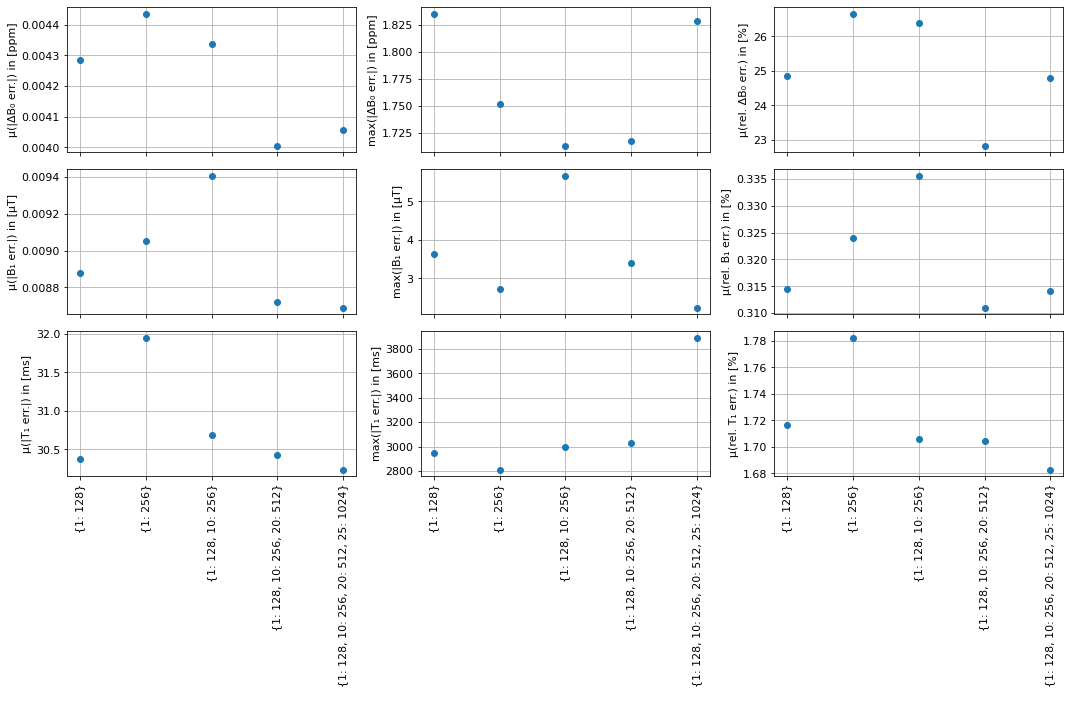

In [58]:
# plot all parameters
fig = plt.figure(figsize=(15,10))
#fig.suptitle('batch size comparision, {}, test dataset = {}'.format(30, "sweep12"))

fig.subplots_adjust(hspace=0.2, wspace=0.3)
counter = 1
for i in batch_df.columns[full_param_check]:
    ax = fig.add_subplot(3,3,counter)
    #batch_df.plot(x='name',y=i, rot=90, marker='o', ls='', grid='both', ax=ax, legend=False, sharex=True)
    batch_df.plot(x='name',y=i, rot=90, marker='o', ls='', grid='both', title='', ax=ax, legend=False, sharex=True)
    ax.set_xlabel(' ')
    ax.set_ylabel(case(i))
    counter += 1
    
plt.tight_layout()
plt.savefig(fname='output/analysis/batchsize_allp_allr.png', transparent=False, facecolor='white')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/batchsize_param.png', transparent=False, facecolor='white')
plt.show()

/tmp/ipykernel_31050/656654717.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in batch_list], rotation=90)


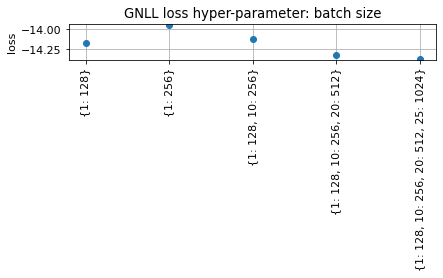

In [59]:
batch_loss_val = extract_val_loss(batchsize_path)

plt.plot([str(i) for i in batch_list], batch_loss_val, marker='o', ls=' ')
ax = plt.gca()
ax.set_xticklabels([str(i) for i in batch_list], rotation=90)
plt.grid('both')
plt.title('GNLL loss hyper-parameter: batch size')
plt.tight_layout()
plt.ylabel('loss')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/batchsize_loss.png', transparent=False, facecolor='white')
plt.show()

<Figure size 432x288 with 0 Axes>

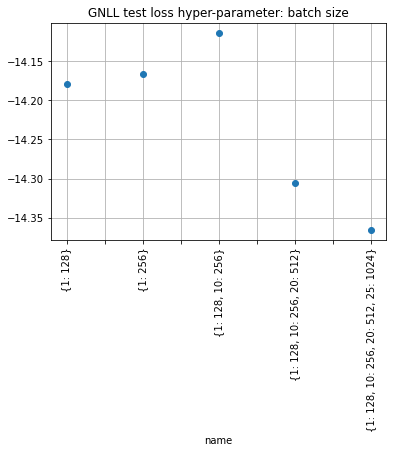

In [71]:
plt.figure()
batch_df.plot(x='name',y='loss mean', rot=90, marker='o', ls='', grid='both', title='GNLL loss hyper-parameter: batch size', legend=False)
#plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/batchsize_loss.png', transparent=False, facecolor='white')
plt.show()

# Activation Functions

In [45]:
# pick all lambdas with 50 epochs
lambda_df = param_check_df.loc[param_check_df['name'].str.contains('relu') | 
                               param_check_df['name'].str.contains('tanh') | 
                               param_check_df['name'].str.contains('sigmoid') | 
                               param_check_df['name'].str.contains('4x128_sweep12_50epochs')].copy()

lambda_df.reset_index(inplace=True, drop=True)
lambda_df.loc[lambda_df['name']=='relu_sweep12_50epochs', 'name'] = 'relu'
lambda_df.loc[lambda_df['name']=='sigmoid_sweep12_50epochs', 'name'] = 'sigmoid'
lambda_df.loc[lambda_df['name']=='tanh_sweep12_50epochs', 'name'] = 'tanh'
lambda_df.loc[lambda_df['name']=='4x128_sweep12_50epochs', 'name'] = 'elu'

act_df = lambda_df.copy()
# act_df
act_df

,name,mean_abs_dB0,max_abs_dB0,mean_rel_dB0,dB0_r2,dB0_pears,dB0_std,mean_abs_B1,max_abs_B1,mean_rel_B1,...,T1_pears,T1_std,mean_abs_T2,max_abs_T2,mean_rel_T2,T2_r2,T2_pears,T2_std,loss mean,loss std
0,relu,0.005024,1.863911,31.831577,0.997982,0.998991,0.020895,0.010756,3.569836,0.386720,...,0.998432,71.933649,0.0,0.0,0.0,0.0,0.0,0.0,-13.653333,NaN
1,sigmoid,0.008816,1.779750,32.574844,0.985433,0.992700,0.057066,0.016093,4.271282,0.517151,...,0.998171,77.890530,0.0,0.0,0.0,0.0,0.0,0.0,-13.000602,NaN
2,tanh,0.005880,1.807898,22.014383,0.992023,0.996005,0.042323,0.011148,3.854511,0.394498,...,0.998482,71.616590,0.0,0.0,0.0,0.0,0.0,0.0,-13.702557,NaN
3,elu,0.005659,1.859559,26.543743,0.992347,0.996168,0.041470,0.010716,4.199571,0.373318,...,0.998503,70.380531,0.0,0.0,0.0,0.0,0.0,0.0,-13.838357,NaN


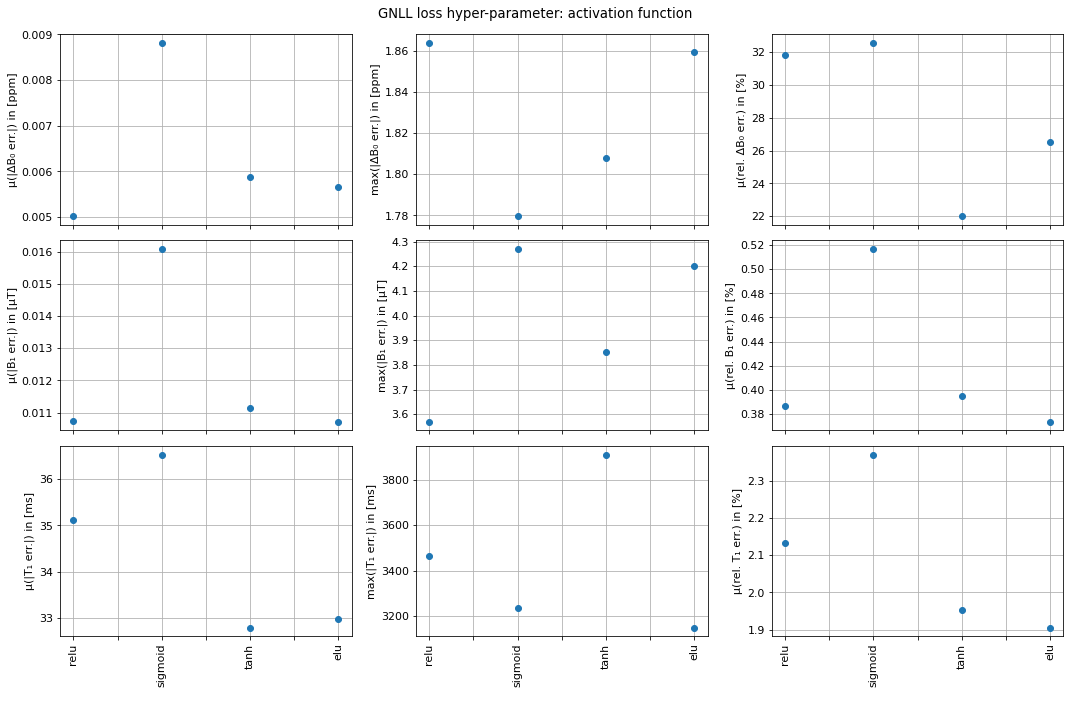

In [60]:
# plot all parameters
fig = plt.figure(figsize=(15,10))
fig.suptitle('GNLL loss hyper-parameter: activation function')
fig.subplots_adjust(hspace=0.2, wspace=0.3)
counter = 1
for i in act_df.columns[full_param_check]:
    ax = fig.add_subplot(3,3,counter)
    act_df.plot(x='name',y=i, rot=90, marker='o', ls='', grid='both', title='', ax=ax, legend=False, sharex=True)
    ax.set_xlabel(' ')
    ax.set_ylabel(case(i))
    counter += 1
    
plt.tight_layout()
plt.savefig(fname='output/analysis/activation_function_allp_allr.png', transparent=False, facecolor='white')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/act_fct_param.png', transparent=False, facecolor='white')
plt.show()

<Figure size 432x288 with 0 Axes>

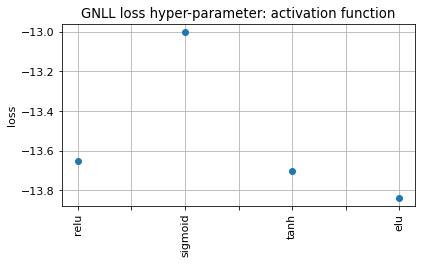

In [47]:
plt.figure()
act_df.plot(x='name',y='loss mean', rot=90, marker='o', ls='', grid='both', title='GNLL loss hyper-parameter: activation function', legend=False)
plt.xlabel(' ')
plt.ylabel('loss')
plt.tight_layout()
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/act_fct_loss.png', transparent=False, facecolor='white')
plt.show()

# Dropout Percentage

In [48]:
# pick all lambdas with 50 epochs
lambda_df = param_check_df.loc[param_check_df['name'].str.contains('dropout01_sweep12_30epochs') | 
                               param_check_df['name'].str.contains('dropout03_sweep12_30epochs') | 
                               param_check_df['name'].str.contains('dropout05_sweep12_30epochs') | 
                               param_check_df['name'].str.contains('dropout10_sweep12_30epochs') | 
                               param_check_df['name'].str.contains('dropout15_sweep12_30epochs')].copy()

lambda_df.reset_index(inplace=True, drop=True)
lambda_df.loc[lambda_df['name']=='dropout01_sweep12_30epochs', 'name'] = '1 %'
lambda_df.loc[lambda_df['name']=='dropout03_sweep12_30epochs', 'name'] = '3 %'
lambda_df.loc[lambda_df['name']=='dropout05_sweep12_30epochs', 'name'] = '5 %'
lambda_df.loc[lambda_df['name']=='dropout10_sweep12_30epochs', 'name'] = '10 %'
lambda_df.loc[lambda_df['name']=='dropout15_sweep12_30epochs', 'name'] = '15 %'

dropout_df = lambda_df.copy()
# act_df
dropout_df

,name,mean_abs_dB0,max_abs_dB0,mean_rel_dB0,dB0_r2,dB0_pears,dB0_std,mean_abs_B1,max_abs_B1,mean_rel_B1,...,T1_pears,T1_std,mean_abs_T2,max_abs_T2,mean_rel_T2,T2_r2,T2_pears,T2_std,loss mean,loss std
0,1 %,0.009898,1.801941,47.052719,0.992072,0.996033,0.041432,0.028500,4.243634,1.116726,...,0.993398,155.092806,1024.024048,4677.510742,290.262268,0.072206,0.269040,709.480941,-12.384367,NaN
1,3 %,0.019274,1.640920,107.367912,0.976488,0.988219,0.070784,0.061965,3.563520,2.486863,...,0.983629,245.466322,1052.407959,4717.740723,329.850830,0.042421,0.206368,703.028500,-11.155587,NaN
2,5 %,0.025912,1.767460,153.824203,0.969193,0.984515,0.079876,0.090830,3.289349,3.509808,...,0.995304,118.074425,1056.338501,4727.979980,339.664398,0.032600,0.181142,708.793879,-10.264705,NaN
3,10 %,0.024225,1.715782,128.793579,0.992897,0.996463,0.032233,0.110003,3.343914,3.121860,...,0.991491,163.505062,1077.285767,4556.365723,375.432648,0.013283,0.115608,700.006247,-8.877491,NaN
4,15 %,0.030039,1.816759,137.991684,0.989834,0.994973,0.037746,0.087142,3.208926,2.809177,...,0.986259,210.661307,1083.432983,4130.062988,390.969604,0.003479,0.060716,702.229798,-8.110196,NaN


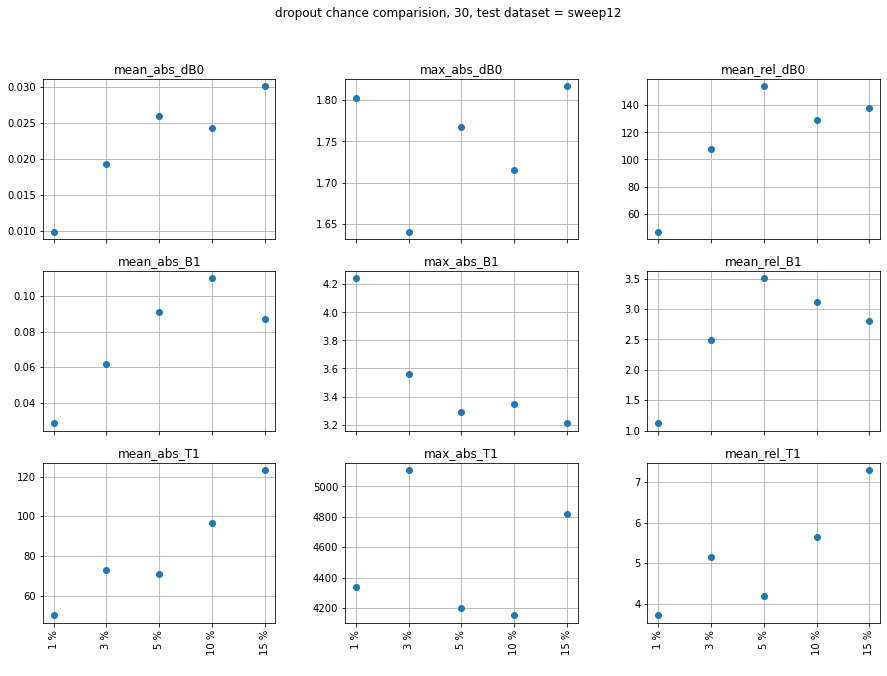

In [95]:
# plot all parameters
fig = plt.figure(figsize=(15,10))
fig.suptitle('dropout chance comparision, {}, test dataset = {}'.format(30, "sweep12"))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
counter = 1
for i in dropout_df.columns[full_param_check]:
    ax = fig.add_subplot(3,3,counter)
    dropout_df.plot(x='name',y=i, rot=90, marker='o', ls='', grid='both', title=i, ax=ax, legend=False, sharex=True)
    ax.set_xlabel(' ')
    counter += 1
    
#plt.savefig(fname='output/analysis/activation_function_allp_allr.png', transparent=False, facecolor='white')
#plt.savefig(fname='output/analysis/activation_function_allp_allr.jpg', transparent=False, facecolor='white')
plt.show()

<Figure size 432x288 with 0 Axes>

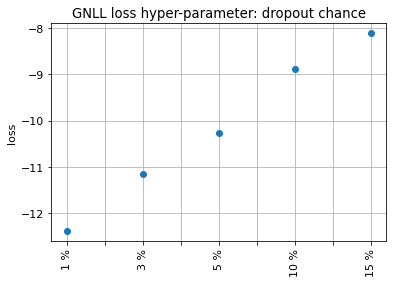

In [50]:
plt.figure()
dropout_df.plot(x='name',y='loss mean', rot=90, marker='o', ls='', grid='both', title='GNLL loss hyper-parameter: dropout chance', legend=False)
plt.xlabel(' ')
plt.ylabel('loss')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/drop_loss.png', transparent=False, facecolor='white')
plt.show()

# net size

In [10]:
import scipy.optimize as sciop
import numpy as np

In [51]:
# pick all lambdas with 50 epochs
lambda_df = param_check_df.loc[param_check_df['name'].str.contains('3x128_sweep12_50epochs') | 
                               param_check_df['name'].str.contains('4x128_sweep12_50epochs') | 
                               param_check_df['name'].str.contains('6x128_sweep12_50epochs') | 
                               param_check_df['name'].str.contains('2x256_sweep12_50epochs') | 
                               param_check_df['name'].str.contains('6x256_sweep12_50epochs')].copy()

lambda_df.reset_index(inplace=True, drop=True)
lambda_df.loc[lambda_df['name']=='2x256_sweep12_50epochs', 'name'] = '2x128; 2x256; 2x128'
lambda_df.loc[lambda_df['name']=='3x128_sweep12_50epochs', 'name'] = '3x128'
lambda_df.loc[lambda_df['name']=='6x128_sweep12_50epochs', 'name'] = '6x128'
lambda_df.loc[lambda_df['name']=='6x256_sweep12_50epochs', 'name'] = '6x256'
lambda_df.loc[lambda_df['name']=='4x128_sweep12_50epochs', 'name'] = '4x128'

netsize_df = lambda_df.copy()
netsize_df = netsize_df.reindex([1,4,2,0,3])
netsize_df.reset_index(inplace=True, drop=True)
# act_df
netsize_df

,name,mean_abs_dB0,max_abs_dB0,mean_rel_dB0,dB0_r2,dB0_pears,dB0_std,mean_abs_B1,max_abs_B1,mean_rel_B1,...,T1_pears,T1_std,mean_abs_T2,max_abs_T2,mean_rel_T2,T2_r2,T2_pears,T2_std,loss mean,loss std
0,3x128,0.008991,1.763850,30.017509,0.985704,0.992850,0.056494,0.016221,4.605808,0.519689,...,0.998243,76.147109,0.0,0.0,0.0,0.0,0.0,0.0,-13.155829,NaN
1,4x128,0.005659,1.859559,26.543743,0.992347,0.996168,0.041470,0.010716,4.199571,0.373318,...,0.998503,70.380531,0.0,0.0,0.0,0.0,0.0,0.0,-13.838357,NaN
2,6x128,0.004171,1.948190,27.841156,0.998288,0.999144,0.019352,0.008944,3.679580,0.320655,...,0.998754,63.819468,0.0,0.0,0.0,0.0,0.0,0.0,-14.230541,NaN
3,2x128; 2x256; 2x128,0.003957,1.958940,22.480354,0.998626,0.999313,0.017285,0.008540,3.656605,0.307646,...,0.998907,59.549600,0.0,0.0,0.0,0.0,0.0,0.0,-14.414004,NaN
4,6x256,0.003708,1.834156,22.277447,0.998973,0.999487,0.014874,0.008261,3.077476,0.296742,...,0.998986,57.194173,0.0,0.0,0.0,0.0,0.0,0.0,-14.548089,NaN


In [80]:
# # attempt to fit a log function onto data
# 
# def expDecay(x, m, t, b):
#     return m * np.log(d * x) + b
# 
# ys = np.array(list(netsize_df['loss mean']))
# xs = np.log(np.array([128**3, 128**4, 128**6, 128**2 *256**2 *128**2, 256**6]))
# print(xs, '\n', ys)
# 
# param, cv = sciop.curve_fit(expDecay, xs, ys, maxfev=1000000 )
# print(param)
# 
# 
# m, d, b = param
# 
# np.square(ys - expDecay(xs, m, d, b)).sum()
# 
# 
# plt.plot(xs, ys, marker='o')
# plt.plot(xs, expDecay(xs, m,d,b), '--',marker='o')

<Figure size 432x288 with 0 Axes>

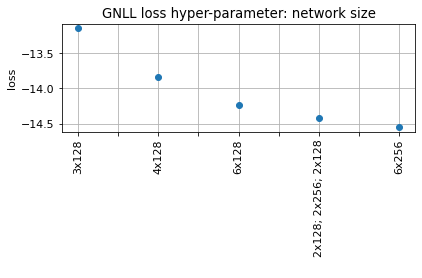

In [52]:
# note x axis not to scale
plt.figure()
netsize_df.plot(x='name',y='loss mean', rot=90, marker='o', ls='', grid='both', title='GNLL loss hyper-parameter: network size', legend=False)
plt.xlabel(' ')
plt.ylabel('loss')
plt.tight_layout()
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/networksize.png', transparent=False, facecolor='white')
plt.show()

In [82]:
tmp = t.load('output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_model_autosave.pt')
tmp['config']

{'ABORT_AFTER_N_OVERFIT_EPOCHS': 20,
 'ABORT_ON_NAN': True,
 'ABORT_ON_OVERFIT': False,
 'AUTOSAVE_FREQ': 1,
 'BATCH_SIZE': {1: 128, 20: 256},
 'CONFIG_NAME': '2021_07_29_sweep12_2x256',
 'DATA_SPLIT': 0.1,
 'DATA_X_PATH': '/data/wasabi/train_data/example_large/20210712_WASABITI_sweep12/20210714_X_WASABITI_sweep12.pt',
 'DATA_Y_PATH': '/data/wasabi/train_data/example_large/20210712_WASABITI_sweep12/20210714_y_WASABITI_sweep12.pt',
 'FORCE_CPUGPU': 'cpu',
 'LAYERS': ['linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'softplus'],
 'LOSS_FKT': 'GNLLonSigma',
 'NET': 'CUSTOM',
 'NOISE': 'gamma_std',
 'NORM_TGTS': {'B1': [0.2, 2.0], 'T1': [0.0, 7.0], 'dB0': [-1.0, 1.0]},
 'N_NEURONS': [31, 128, 128, 256, 256, 128, 128, 6],
 'OPTIMIZER': {1: 'Adam', '1_kwargs': {'lr': 0.0001}},
 'OUTPUT_DIR': 'output/2021_07_29_sweep12_2x256',
 'TYPE_PARAMS': ['dB0', 'B1', 'T1'],
 'VAL_FREQ': 1}

# Noise

## Gamma Distribution

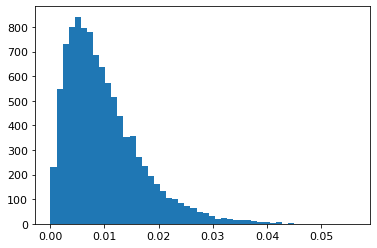

In [54]:
plt.figure()
plt.hist(np.random.gamma(2,0.005,10000), bins=50)
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/damma_distr.png', transparent=False, facecolor='white')
plt.show()

## combined noise

100%|#################| 10/10 [00:05<00:00,  1.99it/s, adding noise =gamma type]


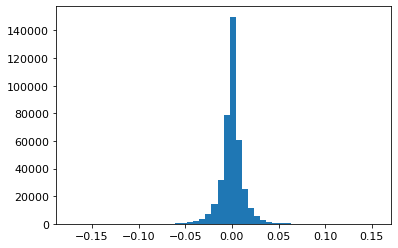

tensor(0.0122)


In [53]:
data = Data()
x = t.zeros([10000,4])
y = t.zeros([10000])
x_noise, y_noise  = data.add_gamma_std_noise(x,y)

plt.figure()
plt.hist(x_noise.flatten().numpy(), bins=50)#, density=True, stacked=True)#, log=True)
plt.show()
print(x_noise.std())

100%|#################| 10/10 [00:05<00:00,  2.00it/s, adding noise =gamma type]


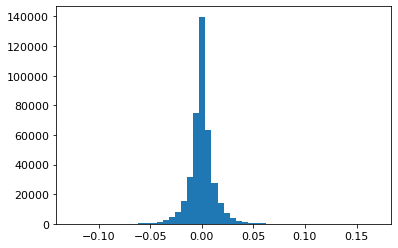

tensor(0.0122)


In [55]:
data = Data()
x = t.zeros([10000,4])
y = t.zeros([10000])
x_noise, y_noise  = data.add_gamma_std_noise(x,y)

plt.figure()
plt.hist(x_noise.flatten().numpy(), bins=50, label='std {}'.format(x_noise.std()))#, density=True, stacked=True)#, log=True)
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/combined_distr.png', transparent=False, facecolor='white')
plt.show()
print(x_noise.std())

100%|#################| 10/10 [00:04<00:00,  2.08it/s, adding noise =gamma type]


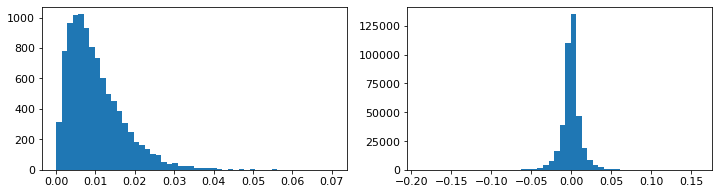

In [56]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plt.hist(np.random.gamma(2,0.005,10000), bins=50)

plt.subplot(1,2,2)
data = Data()
x = t.zeros([10000,4])
y = t.zeros([10000])
x_noise, y_noise  = data.add_gamma_std_noise(x,y)
plt.hist(x_noise.flatten().numpy(), bins=50, label='std {}'.format(x_noise.std()))#, density=True, stacked=True)#, log=True)

plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/noise_distr_both.png', transparent=False, facecolor='white')
plt.show()


# Data no noise

In [184]:
no_noise_sweep12x = t.load(sweep12x)

NameError: name 'sweep12x' is not defined

In [87]:
no_noise_sweep12x_flat = abs(no_noise_sweep12x.flatten())
print(no_noise_sweep12x_flat.max())
print(no_noise_sweep12x_flat.min())

tensor(1.0120)
tensor(1.8301e-07)


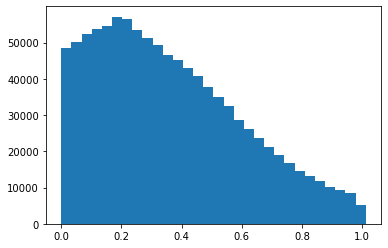

In [88]:
plt.figure()
plt.hist(no_noise_sweep12x_flat.numpy(), bins=30)
plt.show()

# Data with noise

100%|#################| 10/10 [00:16<00:00,  1.64s/it, adding noise =gamma type]


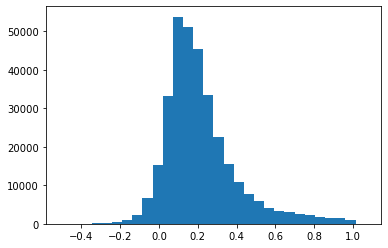

In [89]:
data = Data()
x = t.load(sweep12x)
y = t.load(sweep12y)
x_noise, y_noise  = data.add_gamma_std_noise(x,y)

plt.figure()
plt.hist(x_noise.numpy()[:,0], bins=30)#, density=True, stacked=True)#, log=True)
plt.show()

# Results

## GNLL

### Simulated Data

In [56]:
gnll_data = t.load('output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_epoch50.pt')
gnll_loss_val   = [gnll_data['loss_val'][i][1] for i in range(len(gnll_data['loss_val']))]
gnll_loss_train = [gnll_data['loss_train'][i][1] for i in range(len(gnll_data['loss_val']))]
gnll_data['config']

{'ABORT_AFTER_N_OVERFIT_EPOCHS': 20,
 'ABORT_ON_NAN': True,
 'ABORT_ON_OVERFIT': False,
 'AUTOSAVE_FREQ': 1,
 'BATCH_SIZE': {1: 128, 20: 256},
 'CONFIG_NAME': '2021_07_29_sweep12_2x256',
 'DATA_SPLIT': 0.1,
 'DATA_X_PATH': '/data/wasabi/train_data/example_large/20210712_WASABITI_sweep12/20210714_X_WASABITI_sweep12.pt',
 'DATA_Y_PATH': '/data/wasabi/train_data/example_large/20210712_WASABITI_sweep12/20210714_y_WASABITI_sweep12.pt',
 'FORCE_CPUGPU': 'cpu',
 'LAYERS': ['linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'elu',
  'linear',
  'softplus'],
 'LOSS_FKT': 'GNLLonSigma',
 'NET': 'CUSTOM',
 'NOISE': 'gamma_std',
 'NORM_TGTS': {'B1': [0.2, 2.0], 'T1': [0.0, 7.0], 'dB0': [-1.0, 1.0]},
 'N_NEURONS': [31, 128, 128, 256, 256, 128, 128, 6],
 'OPTIMIZER': {1: 'Adam', '1_kwargs': {'lr': 0.0001}},
 'OUTPUT_DIR': 'output/2021_07_29_sweep12_2x256',
 'TYPE_PARAMS': ['dB0', 'B1', 'T1'],
 'VAL_FREQ': 1}

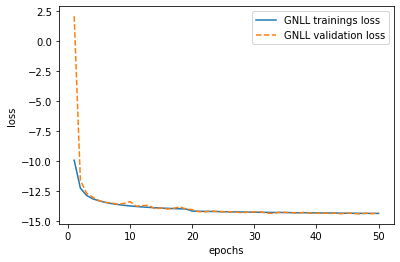

In [91]:
plt.figure()
plt.plot(np.arange(50)+1, gnll_loss_train, label='GNLL trainings loss')
plt.plot(np.arange(50)+1, gnll_loss_val, ls='--', label='GNLL validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_loss.png', transparent=False, facecolor='white')
plt.show()

### COPY into table

In [22]:
# pick all lambdas with 50 epochs
gnll_df = param_check_df.loc[param_check_df['name'].str.contains('2x256_sweep12_50epochs')].copy()
gnll_df.reset_index(inplace=True, drop=True)
gnll_df.loc[gnll_df['name']=='2x256_sweep12_50epochs', 'name'] = 'GNLL 50 epochs'
gnll_df = gnll_df.copy()


# COPY into table | y axis => parameter; x axis the kind of value
gnll_df

,name,mean_abs_dB0,max_abs_dB0,mean_rel_dB0,dB0_r2,dB0_pears,dB0_std,mean_abs_B1,max_abs_B1,mean_rel_B1,...,T1_pears,T1_std,mean_abs_T2,max_abs_T2,mean_rel_T2,T2_r2,T2_pears,T2_std,loss mean,loss std
0,GNLL 50 epochs,0.003957,1.95894,22.480354,0.998626,0.999313,0.017285,0.00854,3.656605,0.307646,...,0.998907,59.5496,0.0,0.0,0.0,0.0,0.0,0.0,-14.414004,NaN


### r2 graph

100%|#################| 10/10 [00:16<00:00,  1.67s/it, adding noise =gamma type]


Warning! Be aware that the two config files are different!


100%|######################################| 2560/2560 [00:09<00:00, 283.16it/s]


INFO: dB0 error should not exceed 0.05 ppm
mean abs. dB0 error (goal <0.008) = 0.0040 ppm
max abs. dB0 error (goal <2.881) = 1.6813 ppm
mean rel. dB0 error = 30.7281 %
 
INFO: abs B1 error should not exceed 0.1 µT
mean abs. B1 error (goal <0.124) = 0.0086 µT
max abs. B1 error (goal <4.774) = 3.3733 µT
mean rel. B1 error = 0.3069 %
 
INFO: abs T1 error should not exceed 50 ms
mean abs. T1 error = 29.4 ms
max abs. T1 error = 3036.0 ms
mean rel. T1 error = 1.629 %
 
evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance


<AxesSubplot:title={'center':'T$_1$ [s] with R² = 0.99784, var(error) = 0.004347 \n lin. reg. g(x) = 0.998160*x + 0.001980'}, xlabel='predictions', ylabel='targets'>

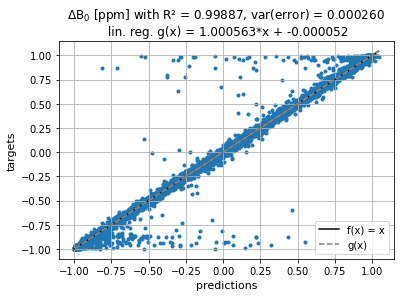

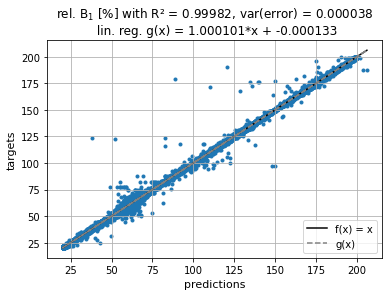

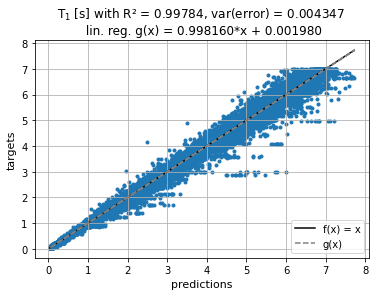

In [105]:
# r2 graph
config1 = load_config('output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
gnll_obj = EvalWasabi(trainer=config1,
                          data_type='BMCTool',
                          net_to_load='output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_epoch50.pt',
                          x_file=sweep12x,
                          y_file=sweep12y)

gnll_obj.predict()
gnll_obj.plot_lin_reg(param='dB0', ens=False, uncer_type='combined', 
                      save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_r2_dB0.png')
gnll_obj.plot_lin_reg(param='B1', ens=False, uncer_type='combined', 
                      save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_r2_B1.png')
gnll_obj.plot_lin_reg(param='T1', ens=False, uncer_type='combined', 
                      save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_r2_T1.png')

### Pearson Correlation for Uncertainty

In [9]:
# r2 graph
config1 = load_config('output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
gnll_obj = EvalWasabi(trainer=config1,
                          data_type='BMCTool',
                          net_to_load='output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_epoch50.pt',
                          x_file=sweep12x,
                          y_file=sweep12y)
gnll_obj.predict()


100%|#################| 10/10 [00:15<00:00,  1.60s/it, adding noise =gamma type]


Warning! Be aware that the two config files are different!


100%|######################################| 2560/2560 [00:09<00:00, 265.69it/s]


In [34]:
pred = gnll_obj.get_predictions()
tgts = gnll_obj.trainer[0].predictions_targets

print(ncorrcoef(pred[:,3].cpu().numpy(), (tgts[:,0]-pred[:,0]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred[:,4].cpu().numpy(), (tgts[:,1]-pred[:,1]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred[:,5].cpu().numpy(), (tgts[:,2]-pred[:,2]).abs().cpu().numpy())[0,1])

0.6615949595883898
0.5841833692672114
0.676084246518875


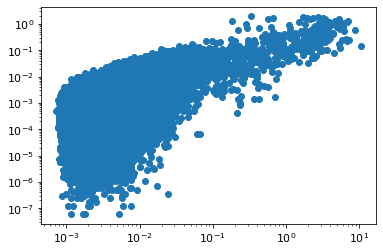

In [38]:
plt.scatter(pred[:,3].cpu().numpy(), (tgts[:,0]-pred[:,0]).abs().cpu().numpy())
plt.xscale('log')
plt.yscale('log')

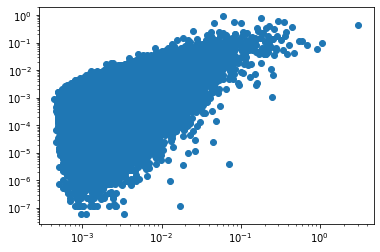

In [102]:
plt.scatter(pred[:,4].cpu().numpy(), (tgts[:,1]-pred[:,1]).abs().cpu().numpy())
plt.xscale('log')
plt.yscale('log')

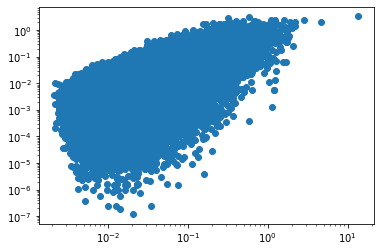

In [103]:
plt.scatter(pred[:,5].cpu().numpy(), (tgts[:,2]-pred[:,2]).abs().cpu().numpy())
plt.xscale('log')
plt.yscale('log')

### Phantom

### full phantom comparison

/home/henrik/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Warning! Be aware that the two config files are different!


100%|########################################| 126/126 [00:00<00:00, 183.95it/s]


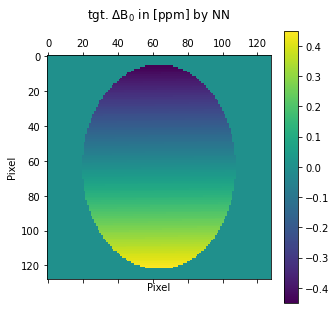

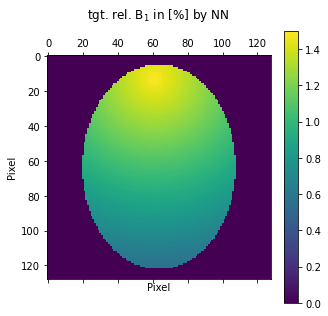

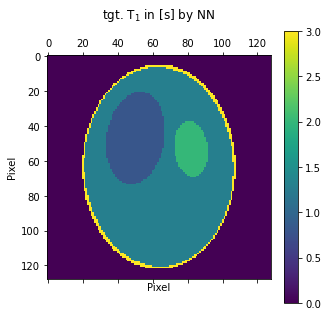

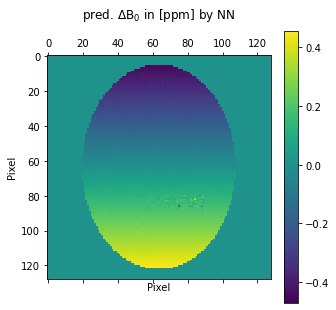

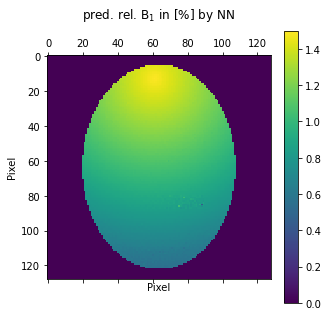

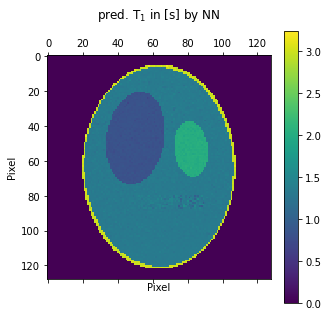

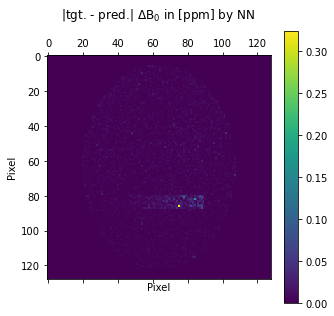

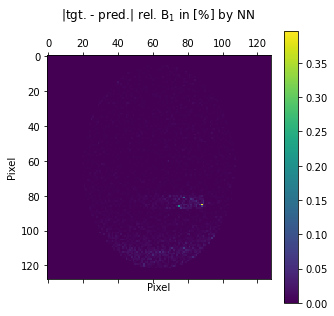

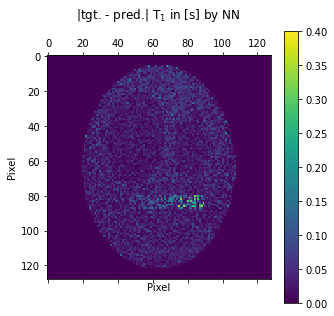

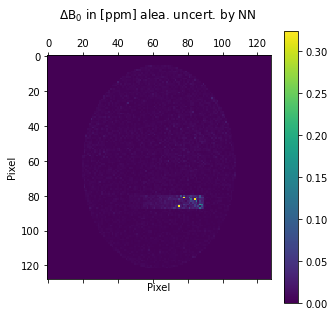

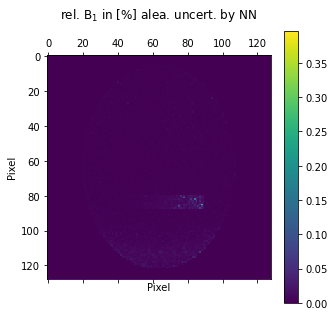

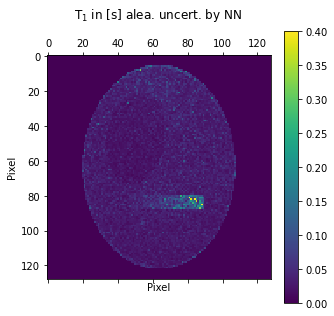

In [8]:
config1 = load_config('output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
gnll_obj = EvalWasabi(trainer=config1,
                      data_type='phantom',
                      net_to_load='output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_epoch50.pt',
                      phantom_filepath='data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p',
                      add_noise=True,
                      noise_scale=1.)

gnll_obj.predict()

# true targets
gnll_obj.plot_parameter(param='dB0', uncertainty=False, tgt=True, 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_dB0_tgt.png')
gnll_obj.plot_parameter(param='B1', uncertainty=False, tgt=True, 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_B1_tgt.png')
gnll_obj.plot_parameter(param='T1', uncertainty=False, tgt=True, 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_tgt.png')

# NN predictions
gnll_obj.plot_parameter(param='dB0', uncertainty=False, tgt=False, 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_dB0_pred.png')
gnll_obj.plot_parameter(param='B1', uncertainty=False, tgt=False, 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_B1_pred.png')
gnll_obj.plot_parameter(param='T1', uncertainty=False, tgt=False, 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_pred.png')

# difference between tgt and pred
gnll_obj.plot_parameter(param='dB0', diff=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_dB0_diff.png')
gnll_obj.plot_parameter(param='B1', diff=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_B1_diff.png')
gnll_obj.plot_parameter(param='T1', diff=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_diff.png')

# aleatoric uncertainty
gnll_obj.plot_parameter(param='dB0', uncertainty=True, uncer_type='aleatoric',
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_dB0_epi.png')
gnll_obj.plot_parameter(param='B1', uncertainty=True, uncer_type='aleatoric',
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_B1_epi.png')
gnll_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='aleatoric', 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_epi.png')

### T1 comparison for different noise levels

Warning! Be aware that the two config files are different!


100%|########################################| 126/126 [00:00<00:00, 186.88it/s]


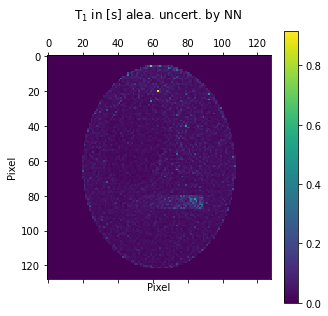

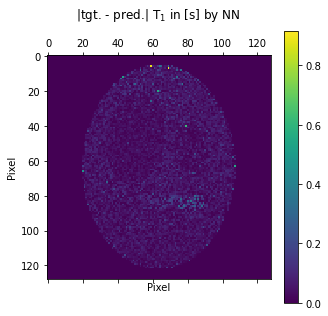

Warning! Be aware that the two config files are different!


100%|########################################| 126/126 [00:00<00:00, 180.24it/s]


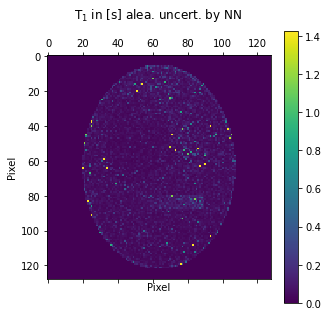

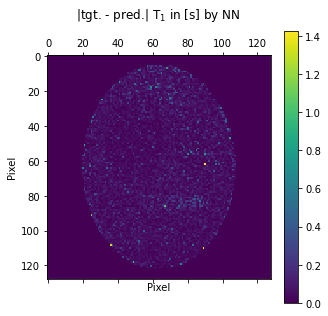

Warning! Be aware that the two config files are different!


100%|########################################| 126/126 [00:00<00:00, 174.11it/s]


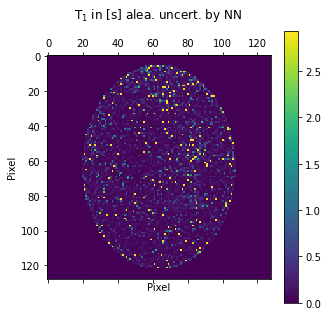

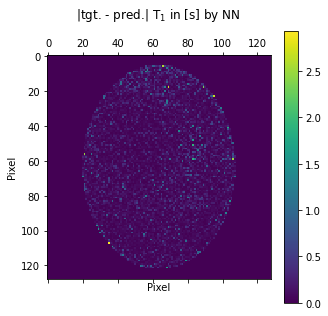

In [9]:
# scale 2; std ~ 0.012
config1 = load_config('output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
gnll_obj = EvalWasabi(trainer=config1,
                      data_type='phantom',
                      net_to_load='output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_epoch50.pt',
                      phantom_filepath='data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p',
                      add_noise=True,
                      noise_scale=2.)
gnll_obj.predict()
gnll_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='aleatoric', 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_epi_sc2.png')
gnll_obj.plot_parameter(param='T1', diff=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_diff_sc2.png')

# scale 4; std ~ 0.048
config1 = load_config('output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
gnll_obj = EvalWasabi(trainer=config1,
                      data_type='phantom',
                      net_to_load='output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_epoch50.pt',
                      phantom_filepath='data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p',
                      add_noise=True,
                      noise_scale=4.)
gnll_obj.predict()
gnll_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='aleatoric', 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_epi_sc4.png')
gnll_obj.plot_parameter(param='T1', diff=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_diff_sc4.png')

# scale 8; std ~ 0.096
config1 = load_config('output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
gnll_obj = EvalWasabi(trainer=config1,
                      data_type='phantom',
                      net_to_load='output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_epoch50.pt',
                      phantom_filepath='data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p',
                      add_noise=True,
                      noise_scale=8.)
gnll_obj.predict()
gnll_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='aleatoric', 
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_epi_sc8.png')
gnll_obj.plot_parameter(param='T1', diff=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/gnll_phan_T1_diff_sc8.png')

### In Vivo

In [ ]:
config1 = load_config('output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
gnll_obj = EvalWasabi(trainer=config1,
                      data_type='scanner',
                      net_to_load='output/2021_07_29_sweep12_2x256/2021_07_29_sweep12_2x256_epoch50.pt',
                      phantom_filepath='data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p',
                      add_noise=False)

In [16]:
filepath = '/home/henrik/work/python/WASABInet/data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p'
with open(filepath, 'rb') as file:
    a = pickle.load(file)

{'b0_shift': array([[ 0.54699887, -0.12666241,  0.76388191, ...,  0.27886905,
          0.86741857,  0.40215917],
        [-0.26960489, -0.06622448,  0.07858367, ...,  0.22259007,
         -0.34837231,  0.22492298],
        [ 0.09660719,  0.69864891, -0.50384255, ..., -0.31864913,
         -0.26642149, -0.06065219],
        ...,
        [-0.21349729,  0.06129424,  0.07587812, ..., -0.2111635 ,
          0.2033976 , -0.18188758],
        [ 0.62564469, -0.7028703 ,  0.6586269 , ...,  0.70800353,
          0.38232618, -0.44821849],
        [ 0.66526359, -0.23260555,  0.13872189, ..., -0.05507285,
         -0.12878711,  0.06211922]]),
 'rel_b1': array([[1.08349443e+00, 1.01981064e+00, 1.10208273e+00, ...,
         1.20007046e+00, 1.12222632e+00, 1.24476565e+00],
        [9.28348185e-01, 1.08050283e+00, 6.54302507e-01, ...,
         1.11527382e+00, 1.08722368e+00, 9.98201262e-01],
        [1.07488612e+00, 1.10940475e+00, 1.10437452e+00, ...,
         1.08743765e+00, 1.11965640e+00, 1.222059

## Ensemble

### Simulated Data

### COPY into Table

In [23]:
ens_df = param_check_df.loc[param_check_df['name'].str.contains('2x256_sweep12_50epochs')].copy()
ens_df.reset_index(inplace=True, drop=True)
ens_df.loc[ens_df['name']=='2x256_sweep12_50epochs', 'name'] = 'ens. 30x 30 epochs'
ens_df = ens_df.copy()


# COPY into table | y axis => parameter; x axis the kind of value
ens_df

,name,mean_abs_dB0,max_abs_dB0,mean_rel_dB0,dB0_r2,dB0_pears,dB0_std,mean_abs_B1,max_abs_B1,mean_rel_B1,...,T1_pears,T1_std,mean_abs_T2,max_abs_T2,mean_rel_T2,T2_r2,T2_pears,T2_std,loss mean,loss std
0,ens. 30 epochs,0.003957,1.95894,22.480354,0.998626,0.999313,0.017285,0.00854,3.656605,0.307646,...,0.998907,59.5496,0.0,0.0,0.0,0.0,0.0,0.0,-14.414004,NaN


### r2 Graph

100%|#################| 10/10 [00:16<00:00,  1.64s/it, adding noise =gamma type]


Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are differen

100%|######################################| 2560/2560 [00:08<00:00, 291.59it/s]


evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance


<AxesSubplot:title={'center':'T$_1$ [s] with R² = 0.99769, var(error) = 0.004646 \n lin. reg. g(x) = 0.999573*x + -0.000418'}, xlabel='predictions', ylabel='targets'>

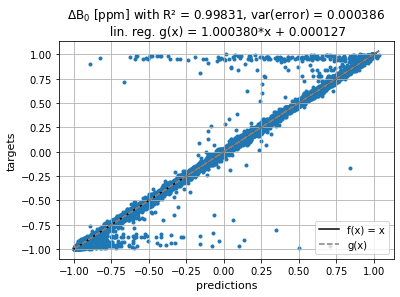

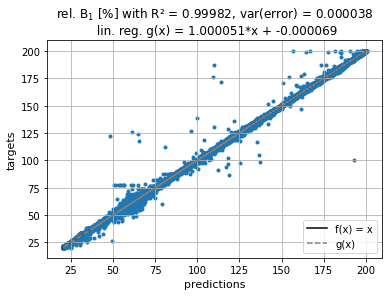

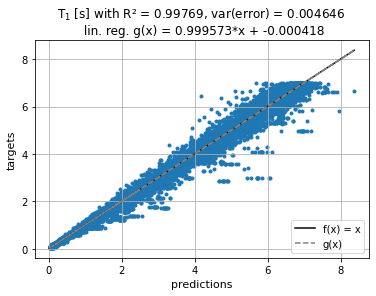

In [31]:
# r2 graph
net = sorted(glob.glob('output/2021_12_09_sweep12_2x256/2021_12_09_sweep12_2x256_epoch30*.pt'))
config1 = load_config('output/2021_12_09_sweep12_2x256/2021_12_09_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
ens_obj = EvalWasabi(trainer=config1,
                          data_type='BMCTool',
                          net_to_load=net,
                          x_file=sweep12x,
                          y_file=sweep12y)

ens_obj.predict()
ens_obj.plot_lin_reg(param='dB0', ens=True, uncer_type='combined', 
                      save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_r2_dB0.png')
ens_obj.plot_lin_reg(param='B1', ens=True, uncer_type='combined', 
                      save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_r2_B1.png')
ens_obj.plot_lin_reg(param='T1', ens=True, uncer_type='combined', 
                      save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_r2_T1.png')

### Pearson Correlation for Uncertainty

In [8]:
net = sorted(glob.glob('output/2021_12_09_sweep12_2x256/2021_12_09_sweep12_2x256_epoch30*.pt'))
config1 = load_config('output/2021_12_09_sweep12_2x256/2021_12_09_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
ens_obj = EvalWasabi(trainer=config1,
                          data_type='BMCTool',
                          net_to_load=net,
                          x_file=sweep12x,
                          y_file=sweep12y)

ens_obj.predict()

100%|#################| 10/10 [00:16<00:00,  1.68s/it, adding noise =gamma type]


Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are differen

100%|######################################| 2560/2560 [00:08<00:00, 300.53it/s]


In [9]:
pred_com = ens_obj.get_predictions(ens=True, uncer_type="combined")
tgts_com = ens_obj.trainer[0].predictions_targets

print(ncorrcoef(pred_com[:,4].cpu().numpy(), (tgts_com[:,0]-pred_com[:,0]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_com[:,5].cpu().numpy(), (tgts_com[:,1]-pred_com[:,1]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_com[:,6].cpu().numpy(), (tgts_com[:,2]-pred_com[:,2]).abs().cpu().numpy())[0,1])

evaluating ensemble mean and variance
0.6659292709960122
0.6807512389871492
0.6833021708442288


In [10]:
pred_ale = ens_obj.get_predictions(ens=True, uncer_type="aleatoric")
tgts_ale = ens_obj.trainer[0].predictions_targets

print(ncorrcoef(pred_ale[:,4].cpu().numpy(), (tgts_ale[:,0]-pred_ale[:,0]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_ale[:,5].cpu().numpy(), (tgts_ale[:,1]-pred_ale[:,1]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_ale[:,6].cpu().numpy(), (tgts_ale[:,2]-pred_ale[:,2]).abs().cpu().numpy())[0,1])

evaluating ensemble mean and variance
0.6603153797851082
0.6731640286802538
0.6837532531489366


In [11]:
pred_epi = ens_obj.get_predictions(ens=True, uncer_type="epistemic")
tgts_epi = ens_obj.trainer[0].predictions_targets

print(ncorrcoef(pred_epi[:,4].cpu().numpy(), (tgts_epi[:,0]-pred_epi[:,0]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_epi[:,5].cpu().numpy(), (tgts_epi[:,1]-pred_epi[:,1]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_epi[:,6].cpu().numpy(), (tgts_epi[:,2]-pred_epi[:,2]).abs().cpu().numpy())[0,1])

evaluating ensemble mean and variance
0.7695076181135708
0.6735940877280352
0.6152853601734912


In [12]:
pred_epi[:,5].isnan().sum()

tensor(0, device='cuda:0')

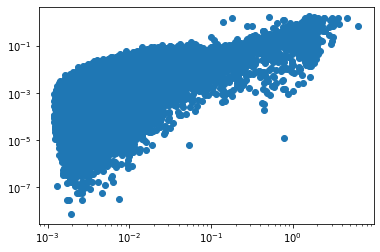

In [104]:
plt.scatter(pred_com[:,4].cpu().numpy(), (tgts_com[:,0]-pred_com[:,0]).abs().cpu().numpy())
plt.xscale('log')
plt.yscale('log')

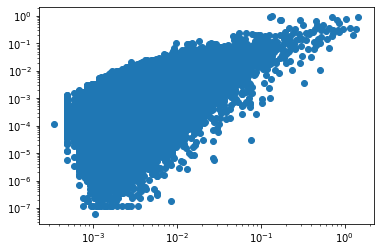

In [105]:
plt.scatter(pred_com[:,5].cpu().numpy(), (tgts_com[:,1]-pred_com[:,1]).abs().cpu().numpy())
plt.xscale('log')
plt.yscale('log')

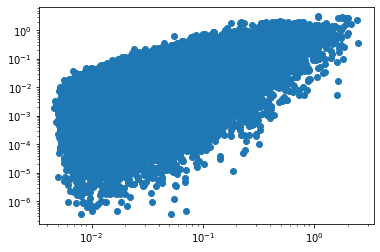

In [106]:
plt.scatter(pred_com[:,6].cpu().numpy(), (tgts_com[:,2]-pred_com[:,2]).abs().cpu().numpy())
plt.xscale('log')
plt.yscale('log')

### Phantom

### full phantom comparison

Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are differen

100%|########################################| 126/126 [00:00<00:00, 404.61it/s]


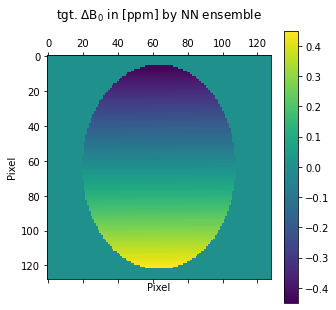

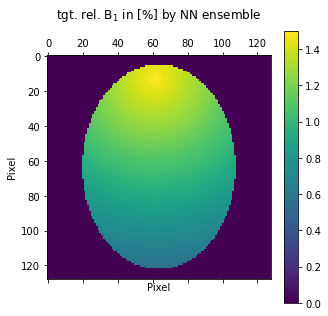

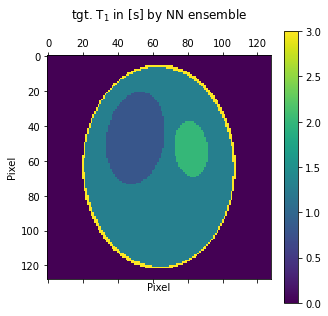

evaluating ensemble mean and variance
evaluating ensemble mean and variance


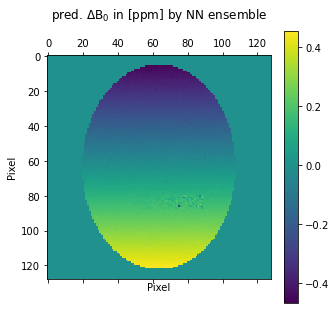

evaluating ensemble mean and variance
evaluating ensemble mean and variance


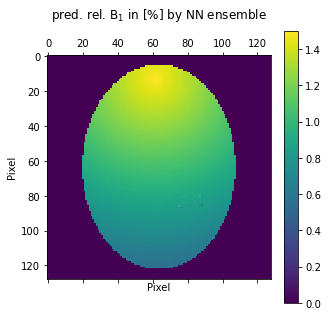

evaluating ensemble mean and variance
evaluating ensemble mean and variance


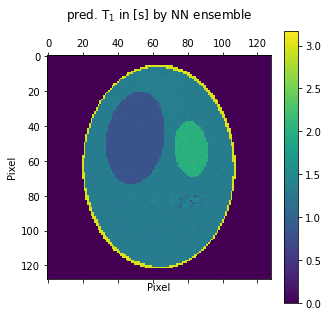

evaluating ensemble mean and variance
evaluating ensemble mean and variance


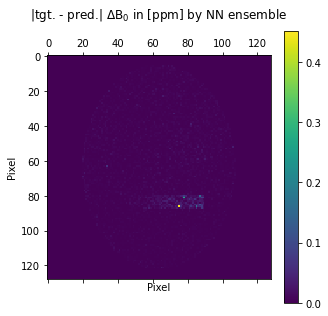

evaluating ensemble mean and variance
evaluating ensemble mean and variance


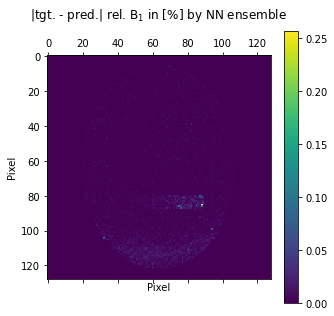

evaluating ensemble mean and variance
evaluating ensemble mean and variance


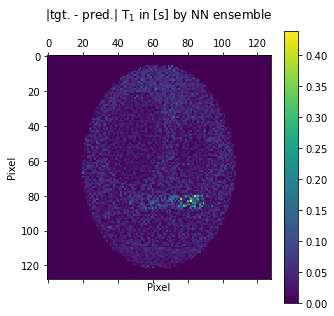

evaluating ensemble mean and variance
evaluating ensemble mean and variance


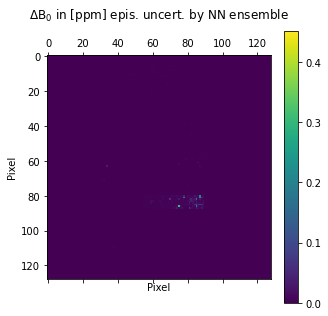

evaluating ensemble mean and variance
evaluating ensemble mean and variance


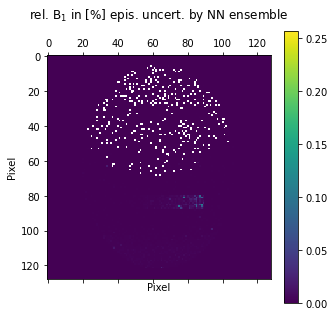

evaluating ensemble mean and variance
evaluating ensemble mean and variance


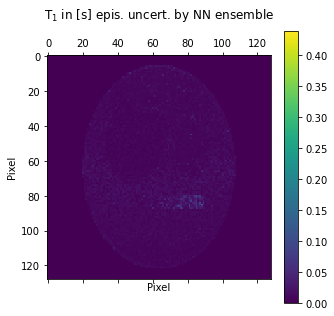

evaluating ensemble mean and variance
evaluating ensemble mean and variance


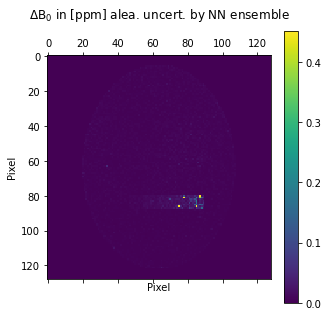

evaluating ensemble mean and variance
evaluating ensemble mean and variance


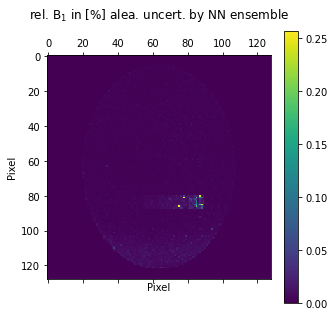

evaluating ensemble mean and variance
evaluating ensemble mean and variance


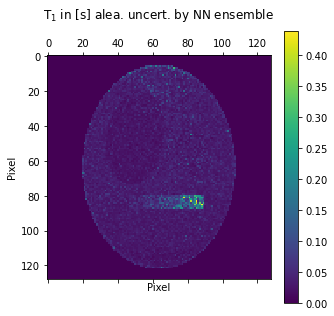

evaluating ensemble mean and variance
evaluating ensemble mean and variance


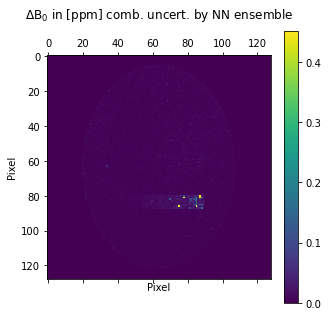

evaluating ensemble mean and variance
evaluating ensemble mean and variance


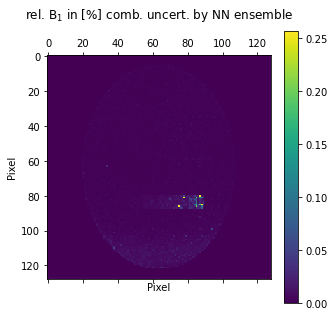

evaluating ensemble mean and variance
evaluating ensemble mean and variance


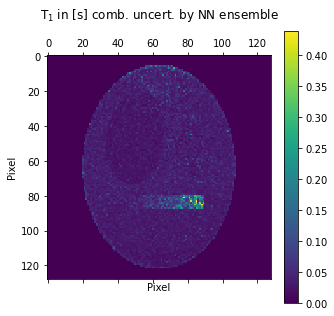

In [32]:
net = sorted(glob.glob('output/2021_12_09_sweep12_2x256/2021_12_09_sweep12_2x256_epoch30*.pt'))
config1 = load_config('output/2021_12_09_sweep12_2x256/2021_12_09_sweep12_2x256.yaml')
config1['FORCE_CPUGPU'] = 'gpu'
ens_obj = EvalWasabi(trainer=config1,
                      data_type='phantom',
                      net_to_load=net,
                      phantom_filepath='data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p',
                      add_noise=True,
                      noise_scale=1.)

ens_obj.predict()

# true targets
ens_obj.plot_parameter(param='dB0', uncertainty=False, tgt=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_dB0_tgt.png')
ens_obj.plot_parameter(param='B1', uncertainty=False, tgt=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_B1_tgt.png')
ens_obj.plot_parameter(param='T1', uncertainty=False, tgt=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_T1_tgt.png')

# NN predictions
ens_obj.plot_parameter(param='dB0', uncertainty=False, tgt=False, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_dB0_pred.png')
ens_obj.plot_parameter(param='B1', uncertainty=False, tgt=False, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_B1_pred.png')
ens_obj.plot_parameter(param='T1', uncertainty=False, tgt=False, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_T1_pred.png')

# difference between tgt and pred
ens_obj.plot_parameter(param='dB0', diff=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_dB0_diff.png')
ens_obj.plot_parameter(param='B1', diff=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_B1_diff.png')
ens_obj.plot_parameter(param='T1', diff=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_T1_diff.png')

# epistemic uncertainty
ens_obj.plot_parameter(param='dB0', uncertainty=True, uncer_type='epistemic', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_dB0_epi.png')
ens_obj.plot_parameter(param='B1', uncertainty=True, uncer_type='epistemic', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_B1_epi.png')
ens_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='epistemic', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_T1_epi.png')

# epistemic uncertainty
ens_obj.plot_parameter(param='dB0', uncertainty=True, uncer_type='aleatoric', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_dB0_ale.png')
ens_obj.plot_parameter(param='B1', uncertainty=True, uncer_type='aleatoric', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_B1_ale.png')
ens_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='aleatoric', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_T1_ale.png')

# epistemic uncertainty
ens_obj.plot_parameter(param='dB0', uncertainty=True, uncer_type='combined', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_dB0_com.png')
ens_obj.plot_parameter(param='B1', uncertainty=True, uncer_type='combined', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_B1_com.png')
ens_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='combined', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/ens_phan_T1_com.png')

### Dropout

In [45]:
### COPY to Table
mcens_df = param_check_df.loc[param_check_df['name'].str.contains('MCdropout_sweep12_30runs_30epochs')].copy()
mcens_df.reset_index(inplace=True, drop=True)
mcens_df.loc[mcens_df['name']=='MCdropout_sweep12_30runs_30epochs', 'name'] = 'MC ens. 30x 30 epochs'
mcens_df = mcens_df.copy()


# COPY into table | y axis => parameter; x axis the kind of value
mcens_df

,name,mean_abs_dB0,max_abs_dB0,mean_rel_dB0,dB0_r2,dB0_pears,dB0_std,mean_abs_B1,max_abs_B1,mean_rel_B1,...,T1_pears,T1_std,mean_abs_T2,max_abs_T2,mean_rel_T2,T2_r2,T2_pears,T2_std,loss mean,loss std
0,MC ens. 30x 30 epochs,0.007258,1.858653,34.865223,0.997826,0.998952,0.021094,0.022027,3.610854,0.886304,...,0.998472,69.783837,1018.12384,4675.051758,289.262177,0.087789,0.305691,699.531913,-12.371714,0.004064


### r2 Graph

100%|#################| 10/10 [00:16<00:00,  1.68s/it, adding noise =gamma type]


Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are differen

100%|######################################| 2560/2560 [00:09<00:00, 277.03it/s]


evaluating ensemble mean and variance
evaluating ensemble mean and variance
evaluating ensemble mean and variance


<AxesSubplot:title={'center':'T$_1$ [s] with R² = 0.99676, var(error) = 0.006517 \n lin. reg. g(x) = 1.014222*x + -0.025996'}, xlabel='predictions', ylabel='targets'>

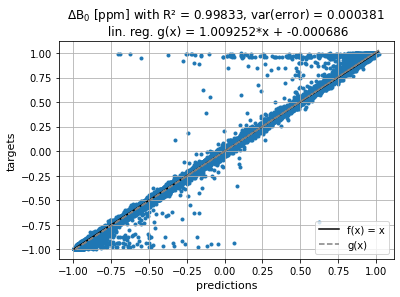

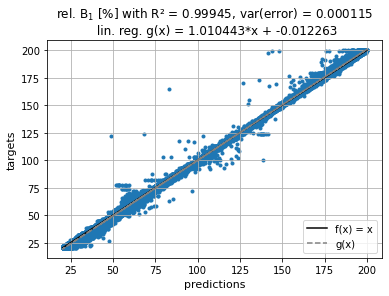

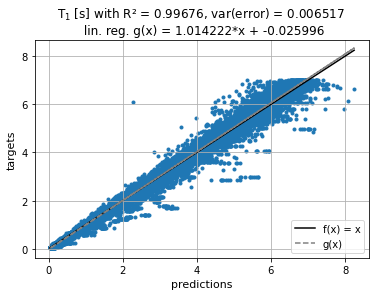

In [47]:
# r2 graph
net_mcens = ['/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01_epoch30.pt'] * 30
config_mcens = load_config('/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01.yaml')
config_mcens['FORCE_CPUGPU'] = 'gpu'
mcens_obj = EvalWasabi(trainer=config_mcens,
                          data_type='BMCTool',
                          net_to_load=net_mcens,
                          x_file=sweep12x,
                          y_file=sweep12y)

mcens_obj.predict()
mcens_obj.plot_lin_reg(param='dB0', ens=True, uncer_type='combined', 
                      save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_r2_dB0.png')
mcens_obj.plot_lin_reg(param='B1', ens=True, uncer_type='combined', 
                      save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_r2_B1.png')
mcens_obj.plot_lin_reg(param='T1', ens=True, uncer_type='combined', 
                      save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_r2_T1.png')

### Pearson Correlation for Uncertainty

In [107]:
# r2 graph
net_mcens = ['/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01_epoch30.pt'] * 30
config_mcens = load_config('/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01.yaml')
config_mcens['FORCE_CPUGPU'] = 'gpu'
mcens_obj = EvalWasabi(trainer=config_mcens,
                          data_type='BMCTool',
                          net_to_load=net_mcens,
                          x_file=sweep12x,
                          y_file=sweep12y)

mcens_obj.predict()

100%|#################| 10/10 [00:16<00:00,  1.65s/it, adding noise =gamma type]


Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are differen

100%|######################################| 2560/2560 [00:09<00:00, 275.31it/s]


In [117]:
pred_com_e = mcens_obj.get_predictions(ens=True, uncer_type="combined")
tgts_com_e = mcens_obj.trainer[0].predictions_targets

print(ncorrcoef(pred_com_e[:,4].cpu().numpy(), (tgts_com_e[:,0]-pred_com_e[:,0]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_com_e[:,5].cpu().numpy(), (tgts_com_e[:,1]-pred_com_e[:,1]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_com_e[:,6].cpu().numpy(), (tgts_com_e[:,2]-pred_com_e[:,2]).abs().cpu().numpy())[0,1])

evaluating ensemble mean and variance
0.29588138053939084
0.5177812070678512
0.1882372706559093


In [118]:
pred_ale_e = mcens_obj.get_predictions(ens=True, uncer_type="aleatoric")
tgts_ale_e = mcens_obj.trainer[0].predictions_targets

print(ncorrcoef(pred_ale_e[:,4].cpu().numpy(), (tgts_ale_e[:,0]-pred_ale_e[:,0]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_ale_e[:,5].cpu().numpy(), (tgts_ale_e[:,1]-pred_ale_e[:,1]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_ale_e[:,6].cpu().numpy(), (tgts_ale_e[:,2]-pred_ale_e[:,2]).abs().cpu().numpy())[0,1])

evaluating ensemble mean and variance
0.2924738748737736
0.5072771834947497
0.1840332368519231


In [119]:
pred_epi_e = mcens_obj.get_predictions(ens=True, uncer_type="epistemic")
tgts_epi_e = mcens_obj.trainer[0].predictions_targets

print(ncorrcoef(pred_ale_e[:,4].cpu().numpy(), (tgts_ale_e[:,0]-pred_ale[:,0]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_ale_e[:,5].cpu().numpy(), (tgts_ale_e[:,1]-pred_ale[:,1]).abs().cpu().numpy())[0,1])
print(ncorrcoef(pred_ale_e[:,6].cpu().numpy(), (tgts_ale_e[:,2]-pred_ale[:,2]).abs().cpu().numpy())[0,1])

evaluating ensemble mean and variance
0.04080382825287019
0.033849494706660835
0.005965373207722022


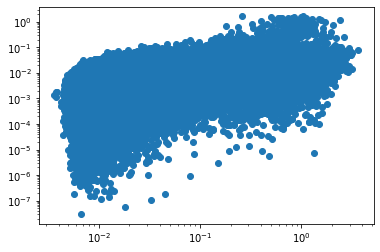

In [120]:
plt.scatter(pred_com_e[:,4].cpu().numpy(), (tgts_com_e[:,0]-pred_com_e[:,0]).abs().cpu().numpy())
plt.xscale('log')
plt.yscale('log')

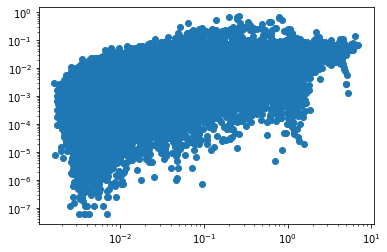

In [121]:
plt.scatter(pred_ale_e[:,5].cpu().numpy(), (tgts_ale_e[:,1]-pred_ale_e[:,1]).abs().cpu().numpy())
plt.xscale('log')
plt.yscale('log')

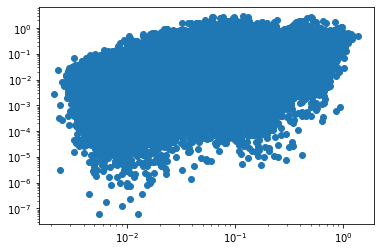

In [122]:
plt.scatter(pred_epi_e[:,6].cpu().numpy(), (tgts_epi_e[:,2]-pred_epi_e[:,2]).abs().cpu().numpy())
plt.xscale('log')
plt.yscale('log')

### full phantom comparison

Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are different!
Warning! Be aware that the two config files are differen

100%|########################################| 126/126 [00:00<00:00, 373.87it/s]


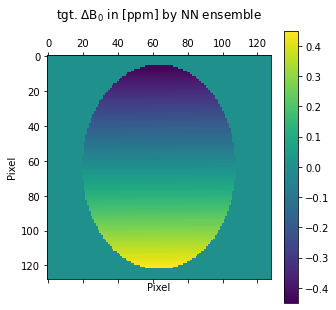

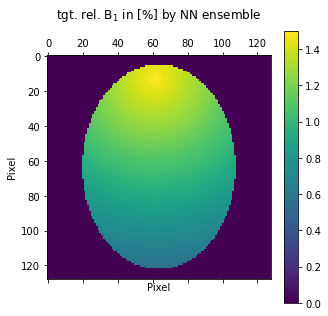

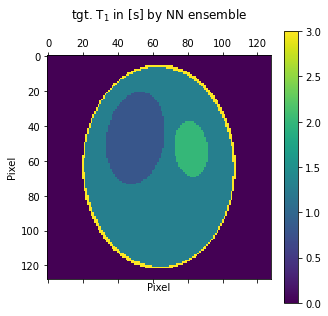

evaluating ensemble mean and variance
evaluating ensemble mean and variance


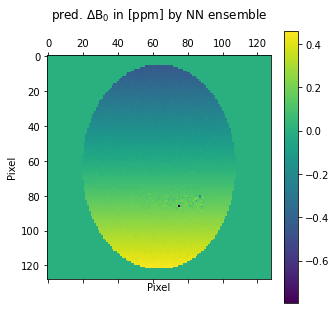

evaluating ensemble mean and variance
evaluating ensemble mean and variance


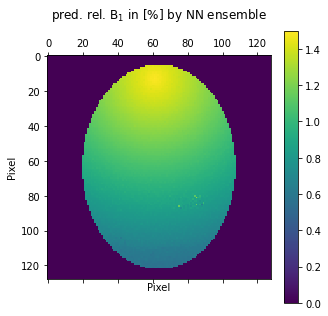

evaluating ensemble mean and variance
evaluating ensemble mean and variance


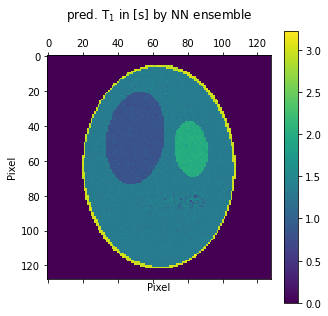

evaluating ensemble mean and variance
evaluating ensemble mean and variance


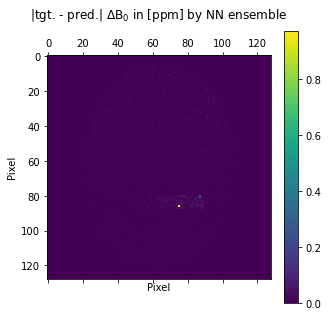

evaluating ensemble mean and variance
evaluating ensemble mean and variance


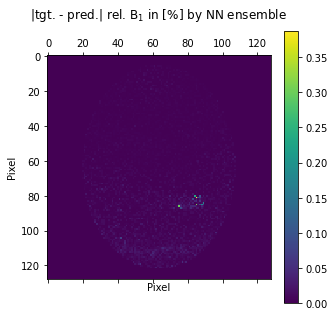

evaluating ensemble mean and variance
evaluating ensemble mean and variance


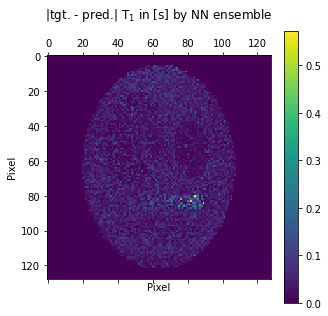

evaluating ensemble mean and variance
evaluating ensemble mean and variance


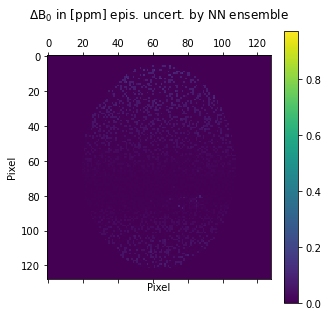

evaluating ensemble mean and variance
evaluating ensemble mean and variance


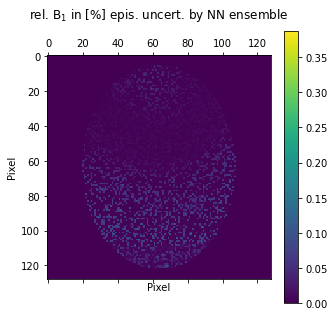

evaluating ensemble mean and variance
evaluating ensemble mean and variance


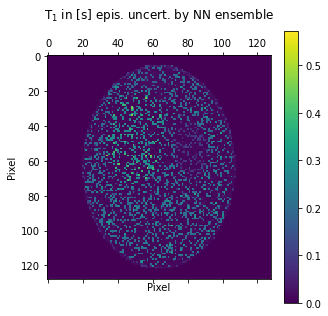

evaluating ensemble mean and variance
evaluating ensemble mean and variance


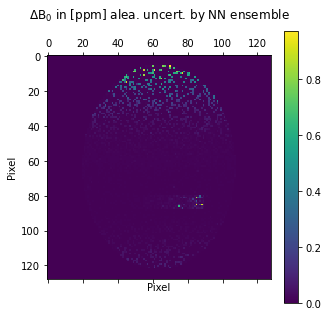

evaluating ensemble mean and variance
evaluating ensemble mean and variance


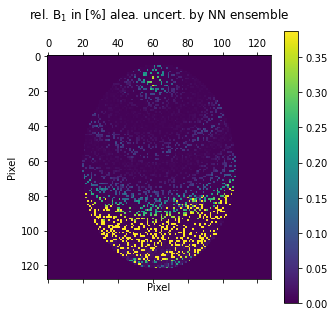

evaluating ensemble mean and variance
evaluating ensemble mean and variance


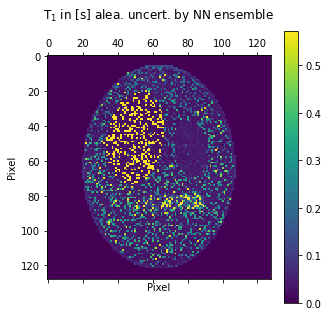

evaluating ensemble mean and variance
evaluating ensemble mean and variance


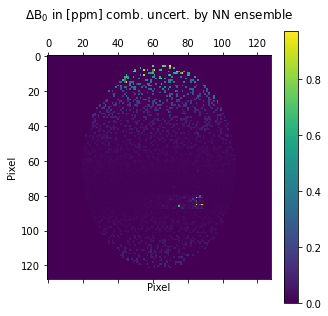

evaluating ensemble mean and variance
evaluating ensemble mean and variance


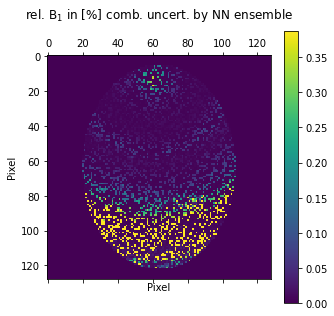

evaluating ensemble mean and variance
evaluating ensemble mean and variance


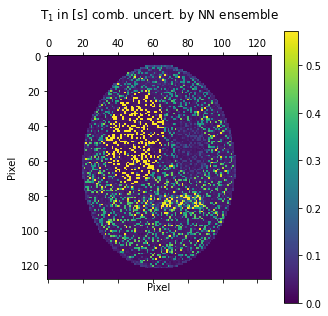

In [48]:
net_mcens = ['/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01_epoch30.pt'] * 30
config_mcens = load_config('/home/henrik/work/python/WASABInet/output/2021_09_24_sweep12_2x256_dropout_01/2021_09_24_sweep12_2x256_dropout_01.yaml')
config_mcens['FORCE_CPUGPU'] = 'gpu'
mcens_obj = EvalWasabi(trainer=config_mcens,
                      data_type='phantom',
                      net_to_load=net_mcens,
                      phantom_filepath='data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p',
                      add_noise=True,
                      noise_scale=1.)

mcens_obj.predict()

# true targets
mcens_obj.plot_parameter(param='dB0', uncertainty=False, tgt=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_dB0_tgt.png')
mcens_obj.plot_parameter(param='B1', uncertainty=False, tgt=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_B1_tgt.png')
mcens_obj.plot_parameter(param='T1', uncertainty=False, tgt=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_T1_tgt.png')

# NN predictions
mcens_obj.plot_parameter(param='dB0', uncertainty=False, tgt=False, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_dB0_pred.png')
mcens_obj.plot_parameter(param='B1', uncertainty=False, tgt=False, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_B1_pred.png')
mcens_obj.plot_parameter(param='T1', uncertainty=False, tgt=False, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_T1_pred.png')

# difference between tgt and pred
mcens_obj.plot_parameter(param='dB0', diff=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_dB0_diff.png')
mcens_obj.plot_parameter(param='B1', diff=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_B1_diff.png')
mcens_obj.plot_parameter(param='T1', diff=True, ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_T1_diff.png')

# epistemic uncertainty
mcens_obj.plot_parameter(param='dB0', uncertainty=True, uncer_type='epistemic', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_dB0_epi.png')
mcens_obj.plot_parameter(param='B1', uncertainty=True, uncer_type='epistemic', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_B1_epi.png')
mcens_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='epistemic', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_T1_epi.png')

# epistemic uncertainty
mcens_obj.plot_parameter(param='dB0', uncertainty=True, uncer_type='aleatoric', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_dB0_ale.png')
mcens_obj.plot_parameter(param='B1', uncertainty=True, uncer_type='aleatoric', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_B1_ale.png')
mcens_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='aleatoric', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_T1_ale.png')

# epistemic uncertainty
mcens_obj.plot_parameter(param='dB0', uncertainty=True, uncer_type='combined', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_dB0_com.png')
mcens_obj.plot_parameter(param='B1', uncertainty=True, uncer_type='combined', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_B1_com.png')
mcens_obj.plot_parameter(param='T1', uncertainty=True, uncer_type='combined', ens=True,
                        save_fig='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/MCens_phan_T1_com.png')

### Phantom Fit Images

In [59]:
# load data
filepath = 'data/analytical_fits/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim_wasabiti_fit_maps_10000_iterations.p'
with open(filepath, 'rb') as file:
    phant = pickle.load(file)
phant.keys()
# phant['b0_shift'], phant['rel_b1'], phant['t1']

dict_keys(['b0_shift', 'rel_b1', 't1', 't2'])

In [60]:
# tgt data
filepath_tgt = 'data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p'
with open(filepath_tgt, 'rb') as file:
    phant_tgt = pickle.load(file)
phant_tgt['phantom'].keys()

dict_keys(['t1', 't2', 'b0_shift', 'b1_inhom', 'fractions', 'noise'])

In [61]:
phant_tgt['phantom']['t2'].mean()

0.0563580322265625

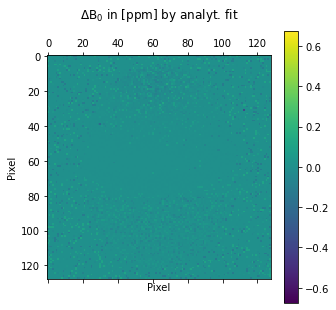

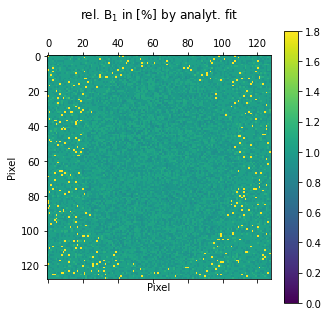

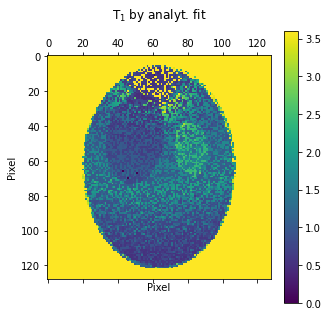

In [62]:
# # plot dB0

fig, ax = plt.subplots(figsize=(5, 5))
difference = phant['b0_shift'].reshape([128,128])

tmp = ax.matshow(phant['b0_shift'].reshape([128,128]),
                 vmin=phant_tgt['phantom']['b0_shift'].min()*1.5,
                 vmax=phant_tgt['phantom']['b0_shift'].max()*1.5)
fig.colorbar(tmp, ax=ax)
ax.set_title('{} by analyt. fit'.format('${\Delta}$B$_0$ in [ppm]'), pad=20)
ax.set_xlabel('Pixel')
ax.set_ylabel('Pixel')
ax.set_facecolor('white')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/fit_phan_dB0.png',
            transparent=False,
            facecolor='white')
plt.show()

# # plot B1

fig, ax = plt.subplots(figsize=(5, 5))
difference = phant['rel_b1'].reshape([128,128])

tmp = ax.matshow(phant['rel_b1'].reshape([128,128]),
                 vmin=phant_tgt['phantom']['b1_inhom'].min()*1.2,
                 vmax=phant_tgt['phantom']['b1_inhom'].max()*1.2)
fig.colorbar(tmp, ax=ax)
ax.set_title('{} by analyt. fit'.format('rel. B$_1$ in [%]'), pad=20)
ax.set_xlabel('Pixel')
ax.set_ylabel('Pixel')
ax.set_facecolor('white')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/fit_phan_B1.png',
            transparent=False,
            facecolor='white')
plt.show()

# # plot T1

fig, ax = plt.subplots(figsize=(5, 5))
difference = phant['t1'].reshape([128,128])

tmp = ax.matshow(phant['t1'].reshape([128,128]),
                 vmin=phant_tgt['phantom']['t1'].min()*1.2,
                 vmax=phant_tgt['phantom']['t1'].max()*1.2)
fig.colorbar(tmp, ax=ax)
ax.set_title('{} by analyt. fit'.format('T$_1$ in [s]'), pad=20)
ax.set_xlabel('Pixel')
ax.set_ylabel('Pixel')
ax.set_facecolor('white')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/fit_phan_T1.png',
            transparent=False,
            facecolor='white')
plt.show()

In [33]:
# # pearson correlation
# Pearson dB0
print(ncorrcoef(phant_tgt['phantom']['b0_shift'].flatten(), phant['b0_shift'].flatten())[0,1])
# Pearson B1
print(ncorrcoef(phant_tgt['phantom']['b1_inhom'].flatten(), phant['rel_b1'].flatten())[0,1])
# Pearson dB0
print(ncorrcoef(phant_tgt['phantom']['t1'].flatten(), phant['t1'].flatten())[0,1])

0.036201286295218384
-0.008527557206825392
-0.006877363068054341


### Histogram of test data distribution

In [38]:
a = t.load('data/testdata/20210720_20210706_WASABITI_sweep12_sim/20210720_y_20210706_WASABITI_sweep12_sim.pt')

In [9]:
a.size()

torch.Size([32768, 4])

In [10]:
a[:,0]

tensor([-0.2663,  0.2283,  0.2333,  ..., -0.5546, -0.1875,  0.4973])

In [41]:
b0_hist, b0_edge = np.histogram(a[:,0], bins=50)
b1_hist, b1_edge = np.histogram(a[:,1], bins=50)
t1_hist, t1_edge = np.histogram(a[:,2], bins=50)

In [45]:
b1_edge

array([0.20000783, 0.23600428, 0.27200073, 0.3079972 , 0.34399363,
       0.3799901 , 0.41598654, 0.451983  , 0.48797944, 0.5239759 ,
       0.55997235, 0.5959688 , 0.6319653 , 0.6679617 , 0.70395815,
       0.73995465, 0.7759511 , 0.8119475 , 0.84794396, 0.88394046,
       0.9199369 , 0.95593333, 0.99192977, 1.0279262 , 1.0639226 ,
       1.0999192 , 1.1359156 , 1.1719121 , 1.2079085 , 1.243905  ,
       1.2799014 , 1.3158978 , 1.3518944 , 1.3878908 , 1.4238873 ,
       1.4598837 , 1.4958801 , 1.5318766 , 1.567873  , 1.6038696 ,
       1.639866  , 1.6758624 , 1.7118589 , 1.7478553 , 1.7838517 ,
       1.8198482 , 1.8558446 , 1.8918412 , 1.9278376 , 1.963834  ,
       1.9998305 ], dtype=float32)

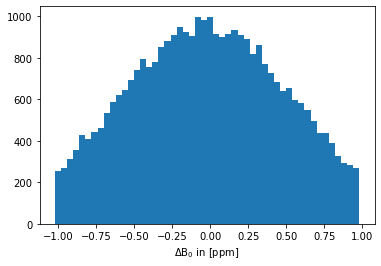

In [53]:
plt.figure()
plt.bar(x=b0_edge[:-1], height=b0_hist, width=(b0_edge[1:]-b0_edge[:-1]))
plt.xlabel('${\Delta}$B$_0$ in [ppm]')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/hist_dB0.png',
            transparent=False,
            facecolor='white')
plt.show()

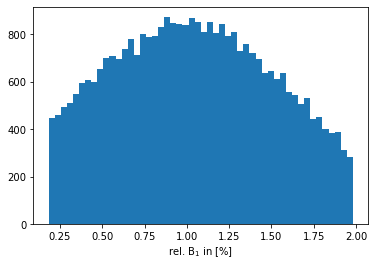

In [54]:
plt.figure()
plt.bar(b1_edge[:-1], b1_hist, width=(b1_edge[1:]-b1_edge[:-1]))
plt.xlabel('rel. B$_1$ in [%]')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/hist_B1.png',
            transparent=False,
            facecolor='white')
plt.show()

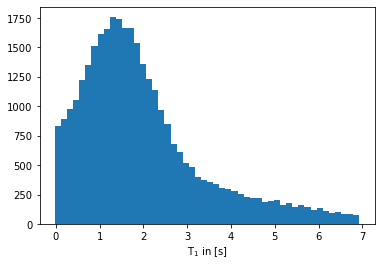

In [55]:
plt.figure()
plt.bar(t1_edge[:-1], t1_hist, width=(t1_edge[1:]-t1_edge[:-1]))
plt.xlabel('T$_1$ in [s]')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/hist_T1.png',
            transparent=False,
            facecolor='white')
plt.show()

### BMCTool WASABITI spectra

In [38]:
import os
import bmctool
from bmctool.bmc_tool import BMCTool
from bmctool.set_params import load_params
from bmctool.simulate import simulate

In [135]:
# select config and seq file
config_name = 'config_WASABITI_sequential'
seq_name = '20210706_WASABITI_sweep12_sim'
config_file = os.path.join('library', config_name + '.yaml')
seq_file = os.path.join('library', seq_name + '.seq')

sim_params = load_params(config_file)
sim_params.print_settings()


 Current parameter settings:
	 water pool:
 {'r1': 0.7692307692307692, 'r2': 13.333333333333334, 'f': 1}
	 CEST pools: 
 []
	 MT pool:
 {}
	 Scanner:
 {'b0': 3, 'gamma': 267.5153, 'b0_inhomogeneity': 0.0, 'rel_b1': 1}
	 Options:
 {'verbose': False, 'reset_init_mag': True, 'scale': 0.0, 'max_pulse_samples': 300, 'par_calc': False}


In [136]:
# params
b0_inhom=[0.3,0.0,-0.3]
rel_b1 = [0.4, 0.5, 0.6, 0.7, 0.8, 1., 1.2]
t1 = [0.8, 1.3, 4.1, 6.]

BMCTool simulation: 100%|███████████████████| 155/155 [00:00<00:00, 1841.05it/s]


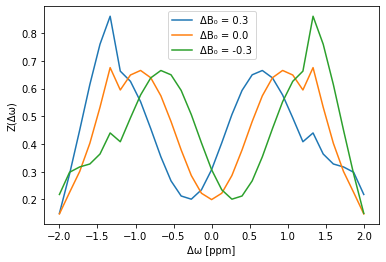

BMCTool simulation: 100%|███████████████████| 155/155 [00:00<00:00, 1806.45it/s]


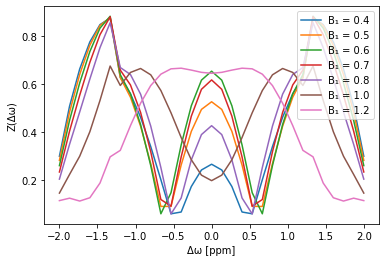

BMCTool simulation: 100%|███████████████████| 155/155 [00:00<00:00, 1853.82it/s]


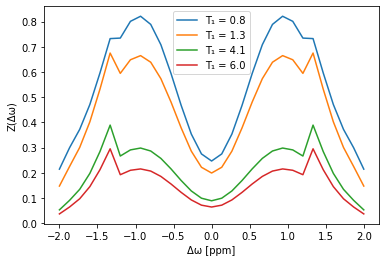

In [138]:
sim = simulate(config_file=config_file, seq_file=seq_file, show_plot=False)

# # dB0
plt.figure()
for i in range(3):
    sim_params.update_scanner(b0_inhom=b0_inhom[i], rel_b1=1.)
    sim_params.update_water_pool(r1=1./1.3, r2=1./0.1)
    sim.params = sim_params
    sim.run()
    plt.plot(sim.get_zspec()[0],sim.get_zspec()[1], label="{} = {}".format(str_param['dB0'], b0_inhom[i]))   
plt.xlabel(delta() + '\u03C9 [ppm]')
plt.ylabel('Z('+delta()+'\u03C9)')
plt.legend()
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/plot_dB0.png',
            transparent=False,
            facecolor='white')
plt.show()

# # B1
plt.figure()
for i in range(7):
    sim_params.update_scanner(b0_inhom=0.0, rel_b1=rel_b1[i])
    sim_params.update_water_pool(r1=1./1.3, r2=1./0.1)
    sim.params = sim_params
    sim.run()
    plt.plot(sim.get_zspec()[0],sim.get_zspec()[1], label="{} = {}".format(str_param['B1'], rel_b1[i]))   
plt.xlabel(delta() + '\u03C9 [ppm]')
plt.ylabel('Z('+delta()+'\u03C9)')   
plt.legend(loc='upper right')
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/plot_B1.png',
            transparent=False,
            facecolor='white')
plt.show()

# # T1
plt.figure()
for i in range(4):
    sim_params.update_scanner(b0_inhom=0.0, rel_b1=1.)
    sim_params.update_water_pool(r1=1./t1[i], r2=1./0.1)
    sim.params = sim_params
    sim.run()
    plt.plot(sim.get_zspec()[0],sim.get_zspec()[1], label="{} = {}".format(str_param['T1'], t1[i]))   
plt.xlabel(delta() + '\u03C9 [ppm]')
plt.ylabel('Z('+delta()+'\u03C9)')   
plt.legend()
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/plot_T1.png',
            transparent=False,
            facecolor='white')
plt.show()

### activation functions

In [133]:
interval = t.arange(-5.,5,0.1)
act_fct = [t.relu, t.sigmoid, t.tanh, t.nn.functional.elu, t.nn.functional.softplus]
label = ['ReLU', 'sigmoid', 'Tanh', 'ELU', 'Softplus']

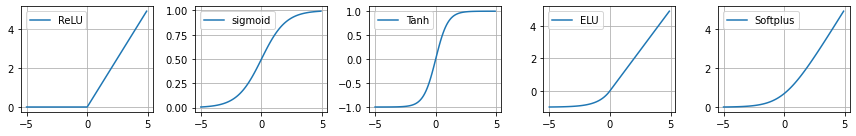

In [134]:
plt.figure(figsize=(12,2))
for i in range(len(act_fct)):
    plt.subplot(1,5,i+1)
    plt.plot(interval, act_fct[i](interval), label=label[i])
    plt.grid('both')
    plt.legend()
    plt.tight_layout()
    
plt.savefig(fname='/home/henrik/Dropbox/Uni/Intermission/Masterarbeit/Gräser/latex/trex-wasabi-master/img/act_plot.png',
            transparent=False,
            facecolor='white')
plt.show()

# Try fitting phantoms

/home/henrik/work/python/WANTED/output/maps/analytical_fits/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim_wasabiti_fit_maps__2022-04-07_16-01.p


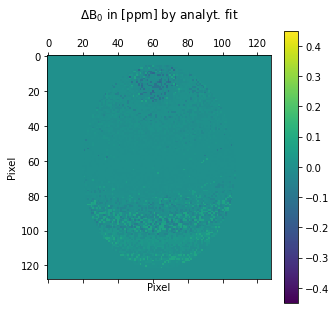

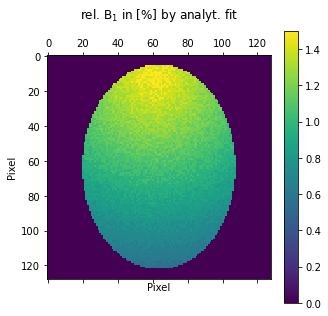

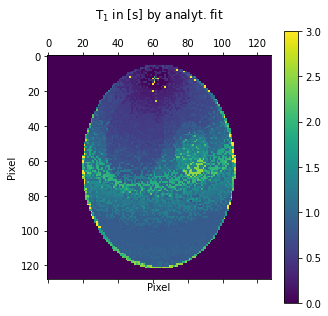

/home/henrik/work/python/WANTED/output/maps/analytical_fits/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim_wasabiti_fit_maps__2022-04-07_16-28.p


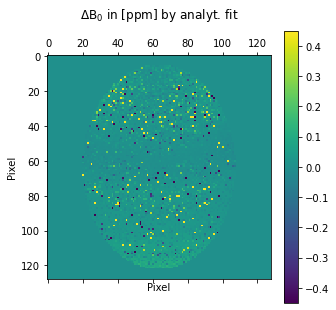

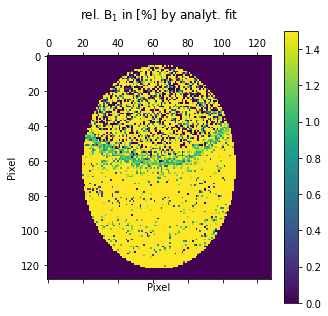

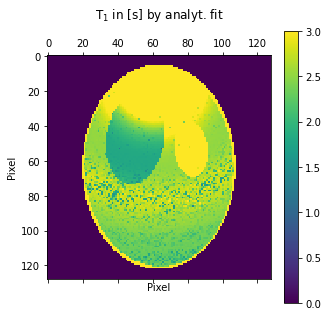

/home/henrik/work/python/WANTED/output/maps/analytical_fits/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim_wasabiti_fit_maps__2022-04-07_16-40.p


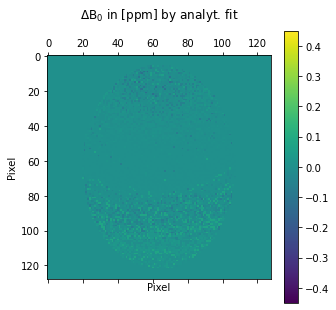

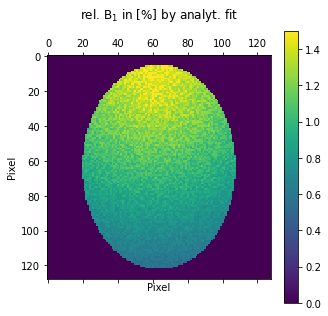

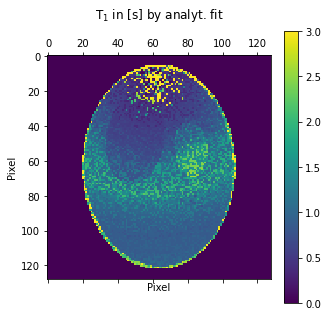

/home/henrik/work/python/WANTED/output/maps/analytical_fits/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim_wasabiti_fit_maps__2022-04-07_16-49.p


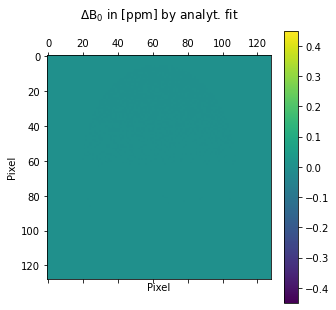

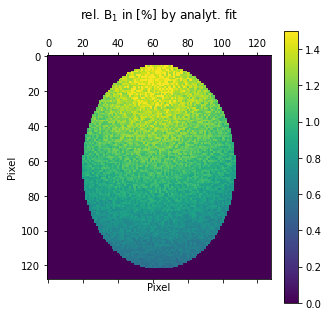

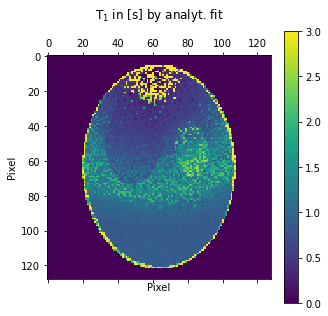

/home/henrik/work/python/WANTED/output/maps/analytical_fits/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim_wasabiti_fit_maps__2022-04-07_16-54.p


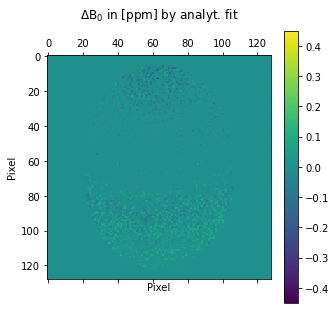

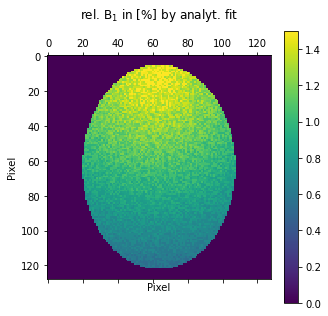

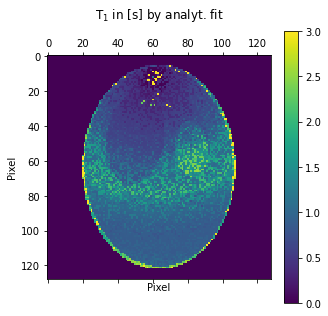

/home/henrik/work/python/WANTED/output/maps/analytical_fits/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim_wasabiti_fit_maps__2022-04-07_17-06.p


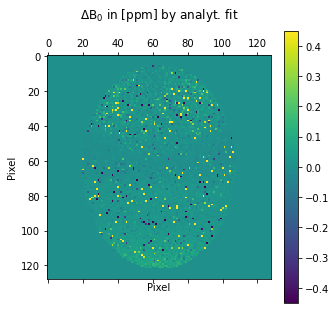

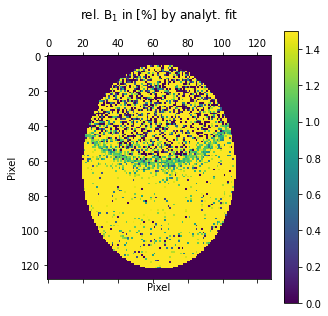

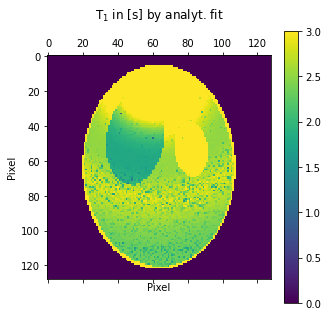

In [183]:
# tgt data
filepaths = glob.glob('/home/henrik/work/python/WANTED/output/maps/analytical_fits/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim_wasabiti_fit_maps__2022-04-07*.p')
filepaths.sort()
#filepath_tgt = 'data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p'

# tgt data
filepath_tgt = 'data/20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim/wanted_phantom_v2__20210706_WASABITIplusKH_128px_fa5_3AHP_trec1p5_sweep12_sim.p'
with open(filepath_tgt, 'rb') as file:
    phant_tgt = pickle.load(file)
phant_tgt['phantom'].keys()

for filepath in filepaths:
    print(filepath)
    with open(filepath, 'rb') as file:
        phant = pickle.load(file)


    # # plot dB0

    fig, ax = plt.subplots(figsize=(5, 5))
    difference = phant['b0_shift'].reshape([128,128])

    tmp = ax.matshow(phant['b0_shift'].reshape([128,128]),
                     vmin=phant_tgt['phantom']['b0_shift'].min(),
                     vmax=phant_tgt['phantom']['b0_shift'].max())
    fig.colorbar(tmp, ax=ax)
    ax.set_title('{} by analyt. fit'.format('${\Delta}$B$_0$ in [ppm]'), pad=20)
    ax.set_xlabel('Pixel')
    ax.set_ylabel('Pixel')
    plt.show()

    # # plot B1

    fig, ax = plt.subplots(figsize=(5, 5))
    difference = phant['rel_b1'].reshape([128,128])

    tmp = ax.matshow(phant['rel_b1'].reshape([128,128]),
                     vmin=phant_tgt['phantom']['b1_inhom'].min(),
                     vmax=phant_tgt['phantom']['b1_inhom'].max())
    fig.colorbar(tmp, ax=ax)
    ax.set_title('{} by analyt. fit'.format('rel. B$_1$ in [%]'), pad=20)
    ax.set_xlabel('Pixel')
    ax.set_ylabel('Pixel')
    plt.show()

    # # plot T1

    fig, ax = plt.subplots(figsize=(5, 5))
    difference = phant['t1'].reshape([128,128])

    tmp = ax.matshow(phant['t1'].reshape([128,128]),
                     vmin=phant_tgt['phantom']['t1'].min(),
                     vmax=phant_tgt['phantom']['t1'].max())
    fig.colorbar(tmp, ax=ax)
    ax.set_title('{} by analyt. fit'.format('T$_1$ in [s]'), pad=20)
    ax.set_xlabel('Pixel')
    ax.set_ylabel('Pixel')
    plt.show()

In [92]:
# take time
print(time.time() - start_time, ' seconds')

4894.683650255203  seconds
